<h1 style="text-align:center; color:#4682B4">Stock Price Prediction with LSTM and Google Trends</h1>

## <span style="color:#4682B4">Project Objective</span>

This project explores the use of LSTM (Long Short-Term Memory) neural networks to predict NVIDIA (NVDA) stock prices, integrating historical stock data with Google Trends data for enhanced predictive accuracy. LSTMs are particularly suited for time series forecasting due to their ability to capture long-term dependencies. By leveraging Google Trends, which provides insights into public interest and search volume for NVIDIA-related terms, the model can incorporate sentiment-driven features. The project demonstrates data preprocessing, feature engineering, and model training. This hybrid approach highlights how combining financial data with external indicators like Google Trends can improve stock price prediction accuracy.

## <span style="color:#4682B4">Business Benefits of Stock Price Prediction with LSTM and Google Trends</span>

1. **Enhanced Decision-Making**:
   - By accurately forecasting stock prices, businesses and investors can make informed decisions on buy/sell strategies, optimizing portfolio management and increasing returns.

2. **Incorporation of Public Sentiment**:
   - Using Google Trends data allows businesses to gauge market sentiment and its impact on stock movements, providing a competitive edge in understanding market dynamics.

3. **Risk Mitigation**:
   - Predictive insights help in identifying potential downturns or market volatility, enabling timely actions to minimize financial losses and manage risks effectively.

4. **Strategic Planning**:
   - Companies can align their strategies with predicted market trends, improving resource allocation and enhancing operational efficiency in trading and investment activities.

## <span style="color:#4682B4"> Import Libraries</span>

In [1216]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from pytrends.request import TrendReq
import yfinance as yf
from datetime import datetime
from math import sqrt
import matplotlib.pyplot as plt

## <span style="color:#4682B4">Combined Dataset</span>

Combining the **sentiment**, **quantitative** ensures **google** across both datasets.

**Sentiment Dataset**

In [1217]:
df_sentiment = pd.read_csv('content/stock_tweets.csv')
# Define a function to display both head and tail of a DataFrame
def display_head_tail(data, n=5):
    # Concatenate the head and tail of the DataFrame
    combined = pd.concat([df_sentiment.head(n), df_sentiment.tail(n)])
    # Display the combined result
    return combined
# Example usage with df_combined
result = display_head_tail(df_sentiment, n=5)
# Display the result
result

Date  \
0      2022-09-29 23:41:16+00:00   
1      2022-09-29 23:24:43+00:00   
2      2022-09-29 23:18:08+00:00   
3      2022-09-29 22:40:07+00:00   
4      2022-09-29 22:27:05+00:00   
80788  2021-10-07 17:11:57+00:00   
80789  2021-10-04 17:05:59+00:00   
80790  2021-10-01 04:43:41+00:00   
80791  2021-10-01 00:03:32+00:00   
80792  2021-09-30 10:22:52+00:00   

                                                   Tweet Stock Name  \
0      Mainstream media has done an amazing job at br...       TSLA   
1      Tesla delivery estimates are at around 364k fr...       TSLA   
2      3/ Even if I include 63.0M unvested RSUs as of...       TSLA   
3      @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA   
4      @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA   
80788  Some of the fastest growing tech stocks on the...       XPEV   
80789  With earnings on the horizon, here is a quick ...       XPEV   
80790  Our record delivery results are a testimony of...       XPEV   
80791  We delivered 10,412 Smart EVs in Sep 2021, rea...       XPEV   
80792  Why can XPeng P5 deliver outstanding performan...       XPEV   

      Company Name  
0      Tesla, Inc.  
1      Tesla, Inc.  
2      Tesla, Inc.  
3      Tesla, Inc.  
4      Tesla, Inc.  
80788   XPeng Inc.  
80789   XPeng Inc.  
80790   XPeng Inc.  
80791   XPeng Inc.  
80792   XPeng Inc.

## <span style="color:#4682B4">Sentiment Analysis DATA is for (2022/09/29-2021/09/30)</span>

## <span style="color:#4682B4">Analyzing Tweet Sentiment with VADER Sentiment Analysis</span>

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a robust tool for sentiment analysis, particularly well-suited for social media text like tweets. It is a lexicon-based sentiment analysis tool designed to capture sentiment intensity, including context-aware aspects like negations, exclamations, and slang.

For this project, VADER is used to analyze tweet sentiment related to specific topics or stock performance. It categorizes sentiments as positive, negative, or neutral, assigning a compound score to indicate overall sentiment strength. This analysis helps uncover public opinion trends, which can be valuable for market sentiment evaluation or understanding user perceptions on social media.

In [1218]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()
# Perform sentiment analysis
df_sentiment['scores'] = df_sentiment['Tweet'].apply(lambda text: analyzer.polarity_scores(text))
df_sentiment['compound'] = df_sentiment['scores'].apply(lambda score_dict: score_dict['compound'])
df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date']).dt.date
# List of stocks to include
selected_stocks = ['AAPL', 'MSFT', 'AMZN', 'META', 'TSLA', 'AMD', 'INTC', 'PYPL']
# Filter the dataset for the selected stocks
filtered_df = df_sentiment[df_sentiment['Stock Name'].isin(selected_stocks)]
# Ensure the Date column is properly formatted (strip time if present)
filtered_df['Date'] = pd.to_datetime(filtered_df['Date']).dt.date
# Group by Date and Stock Name, calculate the mean compound score
average_sentiment_by_date = (
    filtered_df.groupby(['Date', 'Stock Name'], as_index=False)['compound']
    .mean()
    .rename(columns={'compound': 'average_sentiment'})
)
# Verify no duplicates for the same stock and date
duplicates_check = average_sentiment_by_date.duplicated(subset=['Date', 'Stock Name']).sum()
print(f"Number of duplicate rows: {duplicates_check}")
# Display the result
print("Average sentiment scores by date for the selected stocks:")
print(average_sentiment_by_date)
# Example: Filter results for TSLA
stock_name = 'TSLA'
tsla_sentiment = average_sentiment_by_date[average_sentiment_by_date['Stock Name'] == stock_name]
print(f"\nAverage sentiment scores for {stock_name} by date:")
print(tsla_sentiment)


Number of duplicate rows: 0
Average sentiment scores by date for the selected stocks:
            Date Stock Name  average_sentiment
0     2021-09-30       AAPL           0.098900
1     2021-09-30        AMD           0.384217
2     2021-09-30       AMZN           0.256980
3     2021-09-30       META           0.472467
4     2021-09-30       MSFT           0.256980
...          ...        ...                ...
2552  2022-09-29       INTC          -0.827100
2553  2022-09-29       META          -0.051600
2554  2022-09-29       MSFT           0.086080
2555  2022-09-29       PYPL           0.630000
2556  2022-09-29       TSLA           0.057709

[2557 rows x 3 columns]

Average sentiment scores for TSLA by date:
            Date Stock Name  average_sentiment
5     2021-09-30       TSLA           0.251634
11    2021-10-01       TSLA           0.222412
17    2021-10-02       TSLA           0.307714
23    2021-10-03       TSLA           0.267680
30    2021-10-04       TSLA           0.151775

/var/folders/80/hnfw_r755zsgd6zb_n_95hyh0000gn/T/ipykernel_45760/3367321622.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Date'] = pd.to_datetime(filtered_df['Date']).dt.date


Display Sentiment data

In [1219]:
def display_head_tail(data, n=5):
    # Concatenate the head and tail of the DataFrame
    combined = pd.concat([df_sentiment.head(n), df_sentiment.tail(n)])
    # Display the combined result
    return combined
# Example usage with df_combined
result = display_head_tail(df_sentiment, n=5)
# Display the result
result

Date                                              Tweet  \
0      2022-09-29  Mainstream media has done an amazing job at br...   
1      2022-09-29  Tesla delivery estimates are at around 364k fr...   
2      2022-09-29  3/ Even if I include 63.0M unvested RSUs as of...   
3      2022-09-29  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...   
4      2022-09-29  @RealDanODowd @Tesla Stop trying to kill kids,...   
80788  2021-10-07  Some of the fastest growing tech stocks on the...   
80789  2021-10-04  With earnings on the horizon, here is a quick ...   
80790  2021-10-01  Our record delivery results are a testimony of...   
80791  2021-10-01  We delivered 10,412 Smart EVs in Sep 2021, rea...   
80792  2021-09-30  Why can XPeng P5 deliver outstanding performan...   

      Stock Name Company Name  \
0           TSLA  Tesla, Inc.   
1           TSLA  Tesla, Inc.   
2           TSLA  Tesla, Inc.   
3           TSLA  Tesla, Inc.   
4           TSLA  Tesla, Inc.   
80788       XPEV   XPeng Inc.   
80789       XPEV   XPeng Inc.   
80790       XPEV   XPeng Inc.   
80791       XPEV   XPeng Inc.   
80792       XPEV   XPeng Inc.   

                                                  scores  compound  
0      {'neg': 0.125, 'neu': 0.763, 'pos': 0.113, 'co...    0.0772  
1      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...    0.0000  
2      {'neg': 0.0, 'neu': 0.954, 'pos': 0.046, 'comp...    0.2960  
3      {'neg': 0.273, 'neu': 0.59, 'pos': 0.137, 'com...   -0.7568  
4      {'neg': 0.526, 'neu': 0.474, 'pos': 0.0, 'comp...   -0.8750  
80788  {'neg': 0.0, 'neu': 0.925, 'pos': 0.075, 'comp...    0.1779  
80789  {'neg': 0.0, 'neu': 0.938, 'pos': 0.062, 'comp...    0.3818  
80790  {'neg': 0.0, 'neu': 0.903, 'pos': 0.097, 'comp...    0.4215  
80791  {'neg': 0.0, 'neu': 0.889, 'pos': 0.111, 'comp...    0.5423  
80792  {'neg': 0.0, 'neu': 0.805, 'pos': 0.195, 'comp...    0.7783

In [1220]:
# Sort the DataFrame by Stock Name and then by Date
average_sentiment_by_date_sorted = average_sentiment_by_date.sort_values(by=['Stock Name', 'Date'])
# Save to CSV
output_file = "average_sentiment_by_date_sorted.csv"  # Update with your desired file path
average_sentiment_by_date_sorted.to_csv(output_file, index=False)
print(f"Output saved to: {output_file}")

Output saved to: average_sentiment_by_date_sorted.csv


In [1221]:
def display_head_tail(data, n=5):
    # Concatenate the head and tail of the DataFrame
    combined = pd.concat([average_sentiment_by_date_sorted.head(n), average_sentiment_by_date_sorted.tail(n)])
    # Display the combined result
    return combined
# Example usage with df_combined
result = display_head_tail(average_sentiment_by_date_sorted, n=5)
# Display the result
result

Date Stock Name  average_sentiment
0     2021-09-30       AAPL           0.098900
6     2021-10-01       AAPL           0.248255
12    2021-10-02       AAPL           0.007525
18    2021-10-03       AAPL           0.822500
24    2021-10-04       AAPL           0.122830
2529  2022-09-25       TSLA           0.150072
2535  2022-09-26       TSLA           0.114828
2541  2022-09-27       TSLA           0.225460
2548  2022-09-28       TSLA           0.129845
2556  2022-09-29       TSLA           0.057709

In [1222]:

df_sentiment_final = average_sentiment_by_date_sorted
df_sentiment_final.shape

(2557, 3)

## <span style="color:#4682B4">Stock Quantilative DATA is for (2022/09/29-2021/09/30)</span>

In [1223]:
import yfinance as yf
import pandas as pd
def download_stock_data(ticker, start_date="2021-09-30", end_date="2022-09-29"):
    """Download stock data for a given ticker from Yahoo Finance."""
    # Download stock price data, including actions (e.g., dividends)
    data = yf.download(ticker, start=start_date, end=end_date, actions=True)
    data.columns = data.columns.get_level_values(0)  # Flatten any multi-level column structure
    data['Ticker'] = ticker  # Add a column to identify the ticker
    return data
# List of selected stocks
selected_stocks = ['AAPL', 'MSFT', 'AMZN', 'META', 'TSLA', 'AMD', 'INTC', 'PYPL']
# Initialize an empty DataFrame to store all data
df_stock_data = pd.DataFrame()
# Loop through each stock and append the data to the combined DataFrame
for stock in selected_stocks:
    stock_data = download_stock_data(stock)
    df_stock_data = pd.concat([df_stock_data, stock_data], axis=0)
# Reset the index of the combined DataFrame for consistency
df_stock_data.reset_index(inplace=True)
# Keep only the date part in the Date column
df_stock_data['Date'] = pd.to_datetime(df_stock_data['Date']).dt.date
# Display the first few rows of the combined DataFrame
df_stock_data.head()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price        Date   Adj Close       Close  Dividends        High         Low  \
0      2021-09-30  139.016602  141.500000        0.0  144.380005  141.279999   
1      2021-10-01  140.146408  142.649994        0.0  142.919998  139.110001   
2      2021-10-04  136.697983  139.139999        0.0  142.210007  138.270004   
3      2021-10-05  138.633453  141.110001        0.0  142.240005  139.360001   
4      2021-10-06  139.507812  142.000000        0.0  142.149994  138.369995   

Price        Open  Stock Splits    Volume Ticker  
0      143.660004           0.0  89056700   AAPL  
1      141.899994           0.0  94639600   AAPL  
2      141.759995           0.0  98322000   AAPL  
3      139.490005           0.0  80861100   AAPL  
4      139.470001           0.0  83221100   AAPL

In [1224]:
def display_head_tail(data, n=5):
    # Concatenate the head and tail of the DataFrame
    combined = pd.concat([df_stock_data.head(n), df_stock_data.tail(n)])
    # Display the combined result
    return combined
# Example usage with df_combined
result = display_head_tail(df_stock_data, n=5)
# Display the result
result

Price        Date   Adj Close       Close  Dividends        High         Low  \
0      2021-09-30  139.016602  141.500000        0.0  144.380005  141.279999   
1      2021-10-01  140.146408  142.649994        0.0  142.919998  139.110001   
2      2021-10-04  136.697983  139.139999        0.0  142.210007  138.270004   
3      2021-10-05  138.633453  141.110001        0.0  142.240005  139.360001   
4      2021-10-06  139.507812  142.000000        0.0  142.149994  138.369995   
2003   2022-09-22   87.660004   87.660004        0.0   91.500000   87.099998   
2004   2022-09-23   86.970001   86.970001        0.0   87.629997   85.680000   
2005   2022-09-26   84.260002   84.260002        0.0   89.080002   84.129997   
2006   2022-09-27   85.750000   85.750000        0.0   87.695000   84.580002   
2007   2022-09-28   91.120003   91.120003        0.0   91.650002   85.559998   

Price        Open  Stock Splits    Volume Ticker  
0      143.660004           0.0  89056700   AAPL  
1      141.899994           0.0  94639600   AAPL  
2      141.759995           0.0  98322000   AAPL  
3      139.490005           0.0  80861100   AAPL  
4      139.470001           0.0  83221100   AAPL  
2003    90.855003           0.0  12996900   PYPL  
2004    86.919998           0.0  12175900   PYPL  
2005    87.065002           0.0  16936400   PYPL  
2006    85.349998           0.0  11627600   PYPL  
2007    85.830002           0.0  14925900   PYPL

In [1225]:
df_stock_data_final = df_stock_data
df_stock_data_final.shape

(2008, 10)

## <span style="color:#4682B4">Google Trend DATA is for (2022/09/29-2021/09/30)</span>

In [1226]:
# import time
# import pandas as pd
# from pytrends.request import TrendReq

# def fetch_google_trends(keyword, timeframe="2021-09-30 2022-09-29"):
#     """Fetch Google Trends data for the specified keyword."""
#     pytrends = TrendReq(hl='en-US', tz=360)
#     pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='US', gprop='')
#     trends_data = pytrends.interest_over_time()
#     # Drop the 'isPartial' column if it exists
#     if 'isPartial' in trends_data.columns:
#         trends_data = trends_data.drop(columns=['isPartial'])
#     trends_data = trends_data.rename(columns={keyword: 'Google_Trends'})
#     trends_data['Ticker'] = keyword  # Add the Ticker column
#     return trends_data
# # List of selected keywords (stock tickers)
# keywords = ['AAPL', 'MSFT', 'AMZN', 'META', 'TSLA', 'AMD', 'INTC', 'PYPL']
# # Initialize an empty DataFrame for combined data
# combined_trends_data = pd.DataFrame()
# # Loop through each keyword and append the data
# for keyword in keywords:
#     try:
#         keyword_data = fetch_google_trends(keyword)
#         combined_trends_data = pd.concat([combined_trends_data, keyword_data], axis=0)
#     except Exception as e:
#         print(f"Failed to fetch data for {keyword}: {e}")
# # Reset the index and ensure 'Date' is a column
# combined_trends_data.reset_index(inplace=True)
# combined_trends_data.rename(columns={'date': 'Date'}, inplace=True)
# # Save to CSV
# combined_trends_data.to_csv('google_trends_data.csv', index=False)
# # Display the first few rows of the combined DataFrame
# print(combined_trends_data.head())

In [1227]:
df_google_trend = pd.read_csv('content/google_trends_data.csv')
# Define a function to display both head and tail of a DataFrame
def display_head_tail(data, n=5):
    # Concatenate the head and tail of the DataFrame
    combined = pd.concat([df_google_trend.head(n), df_google_trend.tail(n)])
    # Display the combined result
    return combined
# Example usage with df_combined
result = display_head_tail(df_google_trend, n=5)
# Display the result
result

Date  Google_Trends Ticker
0    2021-09-26             51   AAPL
1    2021-10-03             54   AAPL
2    2021-10-10             48   AAPL
3    2021-10-17             55   AAPL
4    2021-10-24             77   AAPL
419  2022-08-28             11   PYPL
420  2022-09-04              9   PYPL
421  2022-09-11             12   PYPL
422  2022-09-18             11   PYPL
423  2022-09-25             10   PYPL

In [1228]:
import pandas as pd
# Load the Google Trends data
df_google_trend = pd.read_csv('content/google_trends_data.csv')
# Convert 'Date' column to datetime format
df_google_trend['Date'] = pd.to_datetime(df_google_trend['Date'])
# Define the complete date range
start_date = "2021-09-30"
end_date = "2022-09-29"
all_dates = pd.date_range(start=start_date, end=end_date)
# Create a DataFrame with all dates for each Ticker
tickers = df_google_trend['Ticker'].unique()
complete_data = pd.DataFrame()
for ticker in tickers:
    # Filter data for the current Ticker
    ticker_data = df_google_trend[df_google_trend['Ticker'] == ticker]
    # Reindex with all dates
    ticker_data = ticker_data.set_index('Date')
    ticker_data = ticker_data.reindex(all_dates, fill_value=0)
    # Reset index and add Ticker column
    ticker_data = ticker_data.reset_index()
    ticker_data.rename(columns={'index': 'Date'}, inplace=True)
    ticker_data['Ticker'] = ticker
    # Append to the complete DataFrame
    complete_data = pd.concat([complete_data, ticker_data])
# Save the complete DataFrame
complete_data.to_csv('content/complete_google_trends_data.csv', index=False)
# Display the first few rows of the complete data
complete_data.head()

Date  Google_Trends Ticker
0 2021-09-30              0   AAPL
1 2021-10-01              0   AAPL
2 2021-10-02              0   AAPL
3 2021-10-03             54   AAPL
4 2021-10-04              0   AAPL

In [1229]:
df_google_trend_complete = pd.read_csv('content/complete_google_trends_data.csv')
# Define a function to display both head and tail of a DataFrame
def display_head_tail(data, n=5):
    # Concatenate the head and tail of the DataFrame
    combined = pd.concat([df_google_trend_complete.head(n), df_google_trend_complete.tail(n)])
    # Display the combined result
    return combined
# Example usage with df_combined
result = display_head_tail(df_google_trend_complete, n=5)
# Display the result
result

Date  Google_Trends Ticker
0     2021-09-30              0   AAPL
1     2021-10-01              0   AAPL
2     2021-10-02              0   AAPL
3     2021-10-03             54   AAPL
4     2021-10-04              0   AAPL
2915  2022-09-25             10   PYPL
2916  2022-09-26              0   PYPL
2917  2022-09-27              0   PYPL
2918  2022-09-28              0   PYPL
2919  2022-09-29              0   PYPL

In [1230]:
df_google_trend_final = df_google_trend_complete
df_google_trend_final.shape

(2920, 3)

Now we have 3 different datasets - lets merge all 3

In [1231]:
print(df_google_trend_final.shape)
print(df_sentiment_final.shape)
print(df_stock_data_final.shape)

(2920, 3)
(2557, 3)
(2008, 10)


In [1232]:
# Rename the column "Stock Name" to "Ticker"
df_sentiment_final.rename(columns={"Stock Name": "Ticker"}, inplace=True)

# Display the updated DataFrame
print(df_sentiment_final.head())

          Date Ticker  average_sentiment
0   2021-09-30   AAPL           0.098900
6   2021-10-01   AAPL           0.248255
12  2021-10-02   AAPL           0.007525
18  2021-10-03   AAPL           0.822500
24  2021-10-04   AAPL           0.122830


In [1233]:

# Convert 'Date' column to datetime format
df_stock_data_final['Date'] = pd.to_datetime(df_stock_data_final['Date'])

# Define the complete date range
start_date = "2021-09-30"
end_date = "2022-09-29"
all_dates = pd.date_range(start=start_date, end=end_date)
# Create a DataFrame with all dates for each Ticker
tickers = df_sentiment_final['Ticker'].unique()
complete_data = pd.DataFrame()
for ticker in tickers:
    # Filter data for the current Ticker
    ticker_data = df_stock_data_final[df_stock_data_final['Ticker'] == ticker]
    
    # Reindex with all dates
    ticker_data = ticker_data.set_index('Date')
    ticker_data = ticker_data.reindex(all_dates, fill_value=0)
    
    # Reset index and add Ticker column
    ticker_data = ticker_data.reset_index()
    ticker_data.rename(columns={'index': 'Date'}, inplace=True)
    ticker_data['Ticker'] = ticker
    
    # Append to the complete DataFrame
    complete_data = pd.concat([complete_data, ticker_data])
df_stock_data_final_adjusted = complete_data

# Display the first few rows of the complete data
df_stock_data_final_adjusted.head()

Price       Date   Adj Close       Close  Dividends        High         Low  \
0     2021-09-30  139.016602  141.500000        0.0  144.380005  141.279999   
1     2021-10-01  140.146408  142.649994        0.0  142.919998  139.110001   
2     2021-10-02    0.000000    0.000000        0.0    0.000000    0.000000   
3     2021-10-03    0.000000    0.000000        0.0    0.000000    0.000000   
4     2021-10-04  136.697983  139.139999        0.0  142.210007  138.270004   

Price        Open  Stock Splits    Volume Ticker  
0      143.660004           0.0  89056700   AAPL  
1      141.899994           0.0  94639600   AAPL  
2        0.000000           0.0         0   AAPL  
3        0.000000           0.0         0   AAPL  
4      141.759995           0.0  98322000   AAPL

In [1234]:
# Save the DataFrame to a CSV file
df_stock_data_final_adjusted.to_csv('df_stock_data_final_adjusted.csv', index=False)

print("DataFrame has been saved to 'df_stock_data_final_adjusted.csv'.")

DataFrame has been saved to 'df_stock_data_final_adjusted.csv'.


In [1235]:
df_stock_data_final_adjusted.shape

(2920, 10)

In [1236]:

# Convert 'Date' column to datetime format
df_sentiment_final['Date'] = pd.to_datetime(df_sentiment_final['Date'])

# Define the complete date range
start_date = "2021-09-30"
end_date = "2022-09-29"
all_dates = pd.date_range(start=start_date, end=end_date)
# Create a DataFrame with all dates for each Ticker
tickers = df_sentiment_final['Ticker'].unique()
complete_data = pd.DataFrame()
for ticker in tickers:
    # Filter data for the current Ticker
    ticker_data = df_sentiment_final[df_sentiment_final['Ticker'] == ticker]
    
    # Reindex with all dates
    ticker_data = ticker_data.set_index('Date')
    ticker_data = ticker_data.reindex(all_dates, fill_value=0)
    
    # Reset index and add Ticker column
    ticker_data = ticker_data.reset_index()
    ticker_data.rename(columns={'index': 'Date'}, inplace=True)
    ticker_data['Ticker'] = ticker
    
    # Append to the complete DataFrame
    complete_data = pd.concat([complete_data, ticker_data])
df_sentiment_final_adjusted = complete_data

# Display the first few rows of the complete data
df_sentiment_final_adjusted.head()

Date Ticker  average_sentiment
0 2021-09-30   AAPL           0.098900
1 2021-10-01   AAPL           0.248255
2 2021-10-02   AAPL           0.007525
3 2021-10-03   AAPL           0.822500
4 2021-10-04   AAPL           0.122830

In [1237]:
print(df_google_trend_final.shape)
print(df_sentiment_final_adjusted.shape)
print(df_stock_data_final_adjusted.shape)

(2920, 3)
(2920, 3)
(2920, 10)


In [1238]:
df_google_trend_final.head()

Date  Google_Trends Ticker
0  2021-09-30              0   AAPL
1  2021-10-01              0   AAPL
2  2021-10-02              0   AAPL
3  2021-10-03             54   AAPL
4  2021-10-04              0   AAPL

In [1239]:
df_sentiment_final_adjusted.head()

Date Ticker  average_sentiment
0 2021-09-30   AAPL           0.098900
1 2021-10-01   AAPL           0.248255
2 2021-10-02   AAPL           0.007525
3 2021-10-03   AAPL           0.822500
4 2021-10-04   AAPL           0.122830

In [1240]:
df_stock_data_final_adjusted.head()

Price       Date   Adj Close       Close  Dividends        High         Low  \
0     2021-09-30  139.016602  141.500000        0.0  144.380005  141.279999   
1     2021-10-01  140.146408  142.649994        0.0  142.919998  139.110001   
2     2021-10-02    0.000000    0.000000        0.0    0.000000    0.000000   
3     2021-10-03    0.000000    0.000000        0.0    0.000000    0.000000   
4     2021-10-04  136.697983  139.139999        0.0  142.210007  138.270004   

Price        Open  Stock Splits    Volume Ticker  
0      143.660004           0.0  89056700   AAPL  
1      141.899994           0.0  94639600   AAPL  
2        0.000000           0.0         0   AAPL  
3        0.000000           0.0         0   AAPL  
4      141.759995           0.0  98322000   AAPL

In [1241]:
import pandas as pd
# Ensure the DataFrames are loaded into your environment
# Example: df_stock_data_final_adjusted = pd.read_csv('df_stock_data_final_adjusted.csv')
# Example: df_google_trend_final = pd.read_csv('df_google_trend_final.csv')
# Convert 'Date' columns to datetime format for consistency
df_stock_data_final_adjusted['Date'] = pd.to_datetime(df_stock_data_final_adjusted['Date'])
df_google_trend_final['Date'] = pd.to_datetime(df_google_trend_final['Date'])
# Merge the 'Google_Trends' column from df_google_trend_final into df_stock_data_final_adjusted
df_stock_data_final_adjusted = pd.merge(
    df_stock_data_final_adjusted,
    df_google_trend_final[['Date', 'Ticker', 'Google_Trends']],
    on=['Date', 'Ticker'],
    how='left'
)


In [1242]:
# Display the first few rows of the updated DataFrame
df_stock_data_final_adjusted.tail()


Date   Adj Close       Close  Dividends        High         Low  \
2915 2022-09-25    0.000000    0.000000        0.0    0.000000    0.000000   
2916 2022-09-26  276.010010  276.010010        0.0  284.089996  270.309998   
2917 2022-09-27  282.940002  282.940002        0.0  288.670013  277.510010   
2918 2022-09-28  287.809998  287.809998        0.0  289.000000  277.570007   
2919 2022-09-29    0.000000    0.000000        0.0    0.000000    0.000000   

            Open  Stock Splits    Volume Ticker  Google_Trends  
2915    0.000000           0.0         0   TSLA             38  
2916  271.829987           0.0  58076900   TSLA              0  
2917  283.839996           0.0  61925200   TSLA              0  
2918  283.079987           0.0  54664800   TSLA              0  
2919    0.000000           0.0         0   TSLA              0

In [1243]:
import pandas as pd
# Ensure the DataFrames are loaded into your environment
# Example: df_stock_data_final_adjusted = pd.read_csv('df_stock_data_final_adjusted.csv')
# Example: df_google_trend_final = pd.read_csv('df_google_trend_final.csv')
# Convert 'Date' columns to datetime format for consistency
df_stock_data_final_adjusted['Date'] = pd.to_datetime(df_stock_data_final_adjusted['Date'])
df_sentiment_final_adjusted['Date'] = pd.to_datetime(df_sentiment_final_adjusted['Date'])
# Merge the 'Google_Trends' column from df_google_trend_final into df_stock_data_final_adjusted
df_stock_data_final_adjusted = pd.merge(
    df_stock_data_final_adjusted,
    df_sentiment_final_adjusted[['Date', 'Ticker', 'average_sentiment']],
    on=['Date', 'Ticker'],
    how='left'
)

In [1244]:
# Display the first few rows of the updated DataFrame
df_stock_data_final_adjusted.head()

Date   Adj Close       Close  Dividends        High         Low  \
0 2021-09-30  139.016602  141.500000        0.0  144.380005  141.279999   
1 2021-10-01  140.146408  142.649994        0.0  142.919998  139.110001   
2 2021-10-02    0.000000    0.000000        0.0    0.000000    0.000000   
3 2021-10-03    0.000000    0.000000        0.0    0.000000    0.000000   
4 2021-10-04  136.697983  139.139999        0.0  142.210007  138.270004   

         Open  Stock Splits    Volume Ticker  Google_Trends  average_sentiment  
0  143.660004           0.0  89056700   AAPL              0           0.098900  
1  141.899994           0.0  94639600   AAPL              0           0.248255  
2    0.000000           0.0         0   AAPL              0           0.007525  
3    0.000000           0.0         0   AAPL             54           0.822500  
4  141.759995           0.0  98322000   AAPL              0           0.122830

In [1245]:
def calculate_technical_indicators(data):
    """Calculate additional technical indicators for the dataset."""
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    
    # RSI Calculation
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    # Daily return
    data['Daily_Return'] = data['Close'].pct_change()
    #data = data.dropna()  # Drop rows with NaN values from rolling calculations
    data['day_of_week'] = data['Date'].dt.dayofweek
    data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)
    data['weighted_sentiment'] = data['average_sentiment'] * data['Google_Trends']
    data['volume_price_tatio'] = data['Volume'] / data['Close']
    data['rsi_volume'] = data['RSI'] * data['Volume']
    data['7d_avg_vlose'] = data['Close'].rolling(window=7).mean()
    data['7d_max_volume'] = data['Volume'].rolling(window=7).max()
    # Replace inf values with NaN
    data.replace([float('inf'), float('-inf')], float('nan'), inplace=True)
    return data


In [1246]:
# Display the first few rows of the updated DataFrame
df_stock_data_final_adjusted = calculate_technical_indicators(df_stock_data_final_adjusted)


In [1247]:
df_stock_data_final_adjusted.head()

Date   Adj Close       Close  Dividends        High         Low  \
0 2021-09-30  139.016602  141.500000        0.0  144.380005  141.279999   
1 2021-10-01  140.146408  142.649994        0.0  142.919998  139.110001   
2 2021-10-02    0.000000    0.000000        0.0    0.000000    0.000000   
3 2021-10-03    0.000000    0.000000        0.0    0.000000    0.000000   
4 2021-10-04  136.697983  139.139999        0.0  142.210007  138.270004   

         Open  Stock Splits    Volume Ticker  ...  SMA_20  RSI  Daily_Return  \
0  143.660004           0.0  89056700   AAPL  ...     NaN  NaN           NaN   
1  141.899994           0.0  94639600   AAPL  ...     NaN  NaN      0.008127   
2    0.000000           0.0         0   AAPL  ...     NaN  NaN     -1.000000   
3    0.000000           0.0         0   AAPL  ...     NaN  NaN           NaN   
4  141.759995           0.0  98322000   AAPL  ...     NaN  NaN           NaN   

   day_of_week  is_weekend  weighted_sentiment  volume_price_tatio  \
0            3           0               0.000       629375.971731   
1            4           0               0.000       663439.215207   
2            5           1               0.000                 NaN   
3            6           1              44.415                 NaN   
4            0           0               0.000       706640.796545   

   rsi_volume  7d_avg_vlose  7d_max_volume  
0         NaN           NaN            NaN  
1         NaN           NaN            NaN  
2         NaN           NaN            NaN  
3         NaN           NaN            NaN  
4         NaN           NaN            NaN  

[5 rows x 22 columns]

In [1248]:
from sklearn.preprocessing import LabelEncoder
# Initialize the LabelEncoder
label_encoder = LabelEncoder()
# Apply Label Encoding to the 'Ticker' column
df_stock_data_final_adjusted['Ticker_Label'] = label_encoder.fit_transform(df_stock_data_final_adjusted['Ticker'])
# Display the first few rows to verify the changes
print(df_stock_data_final_adjusted[['Ticker', 'Ticker_Label']].head())
# If you need to map labels back to the original tickers:
ticker_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Ticker to Label Mapping:", ticker_mapping)

  Ticker  Ticker_Label
0   AAPL             0
1   AAPL             0
2   AAPL             0
3   AAPL             0
4   AAPL             0
Ticker to Label Mapping: {'AAPL': 0, 'AMD': 1, 'AMZN': 2, 'INTC': 3, 'META': 4, 'MSFT': 5, 'PYPL': 6, 'TSLA': 7}


In [1249]:
df_stock_data_final_adjusted.tail()

Date   Adj Close       Close  Dividends        High         Low  \
2915 2022-09-25    0.000000    0.000000        0.0    0.000000    0.000000   
2916 2022-09-26  276.010010  276.010010        0.0  284.089996  270.309998   
2917 2022-09-27  282.940002  282.940002        0.0  288.670013  277.510010   
2918 2022-09-28  287.809998  287.809998        0.0  289.000000  277.570007   
2919 2022-09-29    0.000000    0.000000        0.0    0.000000    0.000000   

            Open  Stock Splits    Volume Ticker  ...        RSI  Daily_Return  \
2915    0.000000           0.0         0   TSLA  ...  50.000000           NaN   
2916  271.829987           0.0  58076900   TSLA  ...  48.837380           NaN   
2917  283.839996           0.0  61925200   TSLA  ...  49.622261      0.025108   
2918  283.079987           0.0  54664800   TSLA  ...  49.388855      0.017212   
2919    0.000000           0.0         0   TSLA  ...  39.858165     -1.000000   

      day_of_week  is_weekend  weighted_sentiment  volume_price_tatio  \
2915            6           1            5.702744                 NaN   
2916            0           0            0.000000       210415.919514   
2917            1           0            0.000000       218863.361369   
2918            2           0            0.000000       189933.638385   
2919            3           0            0.000000                 NaN   

        rsi_volume  7d_avg_vlose  7d_max_volume  Ticker_Label  
2915  0.000000e+00    211.788570     70545400.0             7  
2916  2.836324e+09    207.065713     70545400.0             7  
2917  3.072868e+09    203.381426     70545400.0             7  
2918  2.699832e+09    201.525713     70545400.0             7  
2919  0.000000e+00    160.298571     63748400.0             7  

[5 rows x 23 columns]

In [1250]:
df_stock_data_final_adjusted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                2920 non-null   datetime64[ns]
 1   Adj Close           2920 non-null   float64       
 2   Close               2920 non-null   float64       
 3   Dividends           2920 non-null   float64       
 4   High                2920 non-null   float64       
 5   Low                 2920 non-null   float64       
 6   Open                2920 non-null   float64       
 7   Stock Splits        2920 non-null   float64       
 8   Volume              2920 non-null   int64         
 9   Ticker              2920 non-null   object        
 10  Google_Trends       2920 non-null   int64         
 11  average_sentiment   2920 non-null   float64       
 12  SMA_20              2901 non-null   float64       
 13  RSI                 2907 non-null   float64     

In [1251]:
import pandas as pd
from sklearn.impute import KNNImputer
# Drop non-numeric columns
df_stock_data_final_imp = df_stock_data_final_adjusted
# Define columns to apply imputation
columns_to_impute = ['SMA_20', 'RSI', 'Daily_Return', 'volume_price_tatio','rsi_volume', '7d_avg_vlose', '7d_max_volume']
# Drop 'Volatility' column if it is constant or irrelevant
columns_to_impute = [col for col in columns_to_impute if df_stock_data_final_imp[col].nunique() > 1]
# Select columns for imputation
df_to_impute = df_stock_data_final_imp[columns_to_impute]
# Apply KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_imputed_array = imputer.fit_transform(df_to_impute)
# Convert back to DataFrame
df_imputed = pd.DataFrame(df_imputed_array, columns=columns_to_impute, index=df_to_impute.index)
# Combine imputed data with the original DataFrame
df_stock_data_final_imp.update(df_imputed)
# Display the updated DataFrame
df_stock_data_final_imp.head()

Date   Adj Close       Close  Dividends        High         Low  \
0 2021-09-30  139.016602  141.500000        0.0  144.380005  141.279999   
1 2021-10-01  140.146408  142.649994        0.0  142.919998  139.110001   
2 2021-10-02    0.000000    0.000000        0.0    0.000000    0.000000   
3 2021-10-03    0.000000    0.000000        0.0    0.000000    0.000000   
4 2021-10-04  136.697983  139.139999        0.0  142.210007  138.270004   

         Open  Stock Splits    Volume Ticker  ...        RSI  Daily_Return  \
0  143.660004           0.0  89056700   AAPL  ...  48.310594      0.019106   
1  141.899994           0.0  94639600   AAPL  ...  50.000000      0.008127   
2    0.000000           0.0         0   AAPL  ...  48.788001     -1.000000   
3    0.000000           0.0         0   AAPL  ...  49.910417     -0.216160   
4  141.759995           0.0  98322000   AAPL  ...  50.028530      0.006827   

   day_of_week  is_weekend  weighted_sentiment  volume_price_tatio  \
0            3           0               0.000       629375.971731   
1            4           0               0.000       663439.215207   
2            5           1               0.000       152886.813787   
3            6           1              44.415       432352.654079   
4            0           0               0.000       706640.796545   

     rsi_volume  7d_avg_vlose  7d_max_volume  Ticker_Label  
0  2.709863e+09     56.406286   7.082856e+07             0  
1  0.000000e+00     83.013143   1.194648e+08             0  
2  1.018837e+09    129.706571   3.229456e+07             0  
3  1.906411e+09    121.636322   7.111550e+07             0  
4  2.894815e+09     56.737142   7.399268e+07             0  

[5 rows x 23 columns]

In [1252]:
df_stock_data_final_imp.isna().sum()

Date                  0
Adj Close             0
Close                 0
Dividends             0
High                  0
Low                   0
Open                  0
Stock Splits          0
Volume                0
Ticker                0
Google_Trends         0
average_sentiment     0
SMA_20                0
RSI                   0
Daily_Return          0
day_of_week           0
is_weekend            0
weighted_sentiment    0
volume_price_tatio    0
rsi_volume            0
7d_avg_vlose          0
7d_max_volume         0
Ticker_Label          0
dtype: int64

In [1253]:
df_stock_data_final_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                2920 non-null   datetime64[ns]
 1   Adj Close           2920 non-null   float64       
 2   Close               2920 non-null   float64       
 3   Dividends           2920 non-null   float64       
 4   High                2920 non-null   float64       
 5   Low                 2920 non-null   float64       
 6   Open                2920 non-null   float64       
 7   Stock Splits        2920 non-null   float64       
 8   Volume              2920 non-null   int64         
 9   Ticker              2920 non-null   object        
 10  Google_Trends       2920 non-null   int64         
 11  average_sentiment   2920 non-null   float64       
 12  SMA_20              2920 non-null   float64       
 13  RSI                 2920 non-null   float64     

<h2 style="color:#4682B4">Basic Data Exploration</h2>

## <span style="color:#4682B4">Check Distribution Pattern for Independent Variables</span>

Analyzing the distribution pattern of independent variables is crucial for understanding the underlying data structure. It helps identify trends, outliers, and any potential skewness in the variables. By visualizing the distributions, we can determine whether any transformations or adjustments are needed to make the data more suitable for model training.

Examining the distribution of each variable provides insights into whether the data is normally distributed, if there are any extreme values (outliers), or if the data is skewed in any direction. This information is essential for making decisions on data transformations and improving model performance.

By understanding the distribution patterns, we can ensure that the dataset is well-prepared for model training, leading to better accuracy and robustness in predictions.

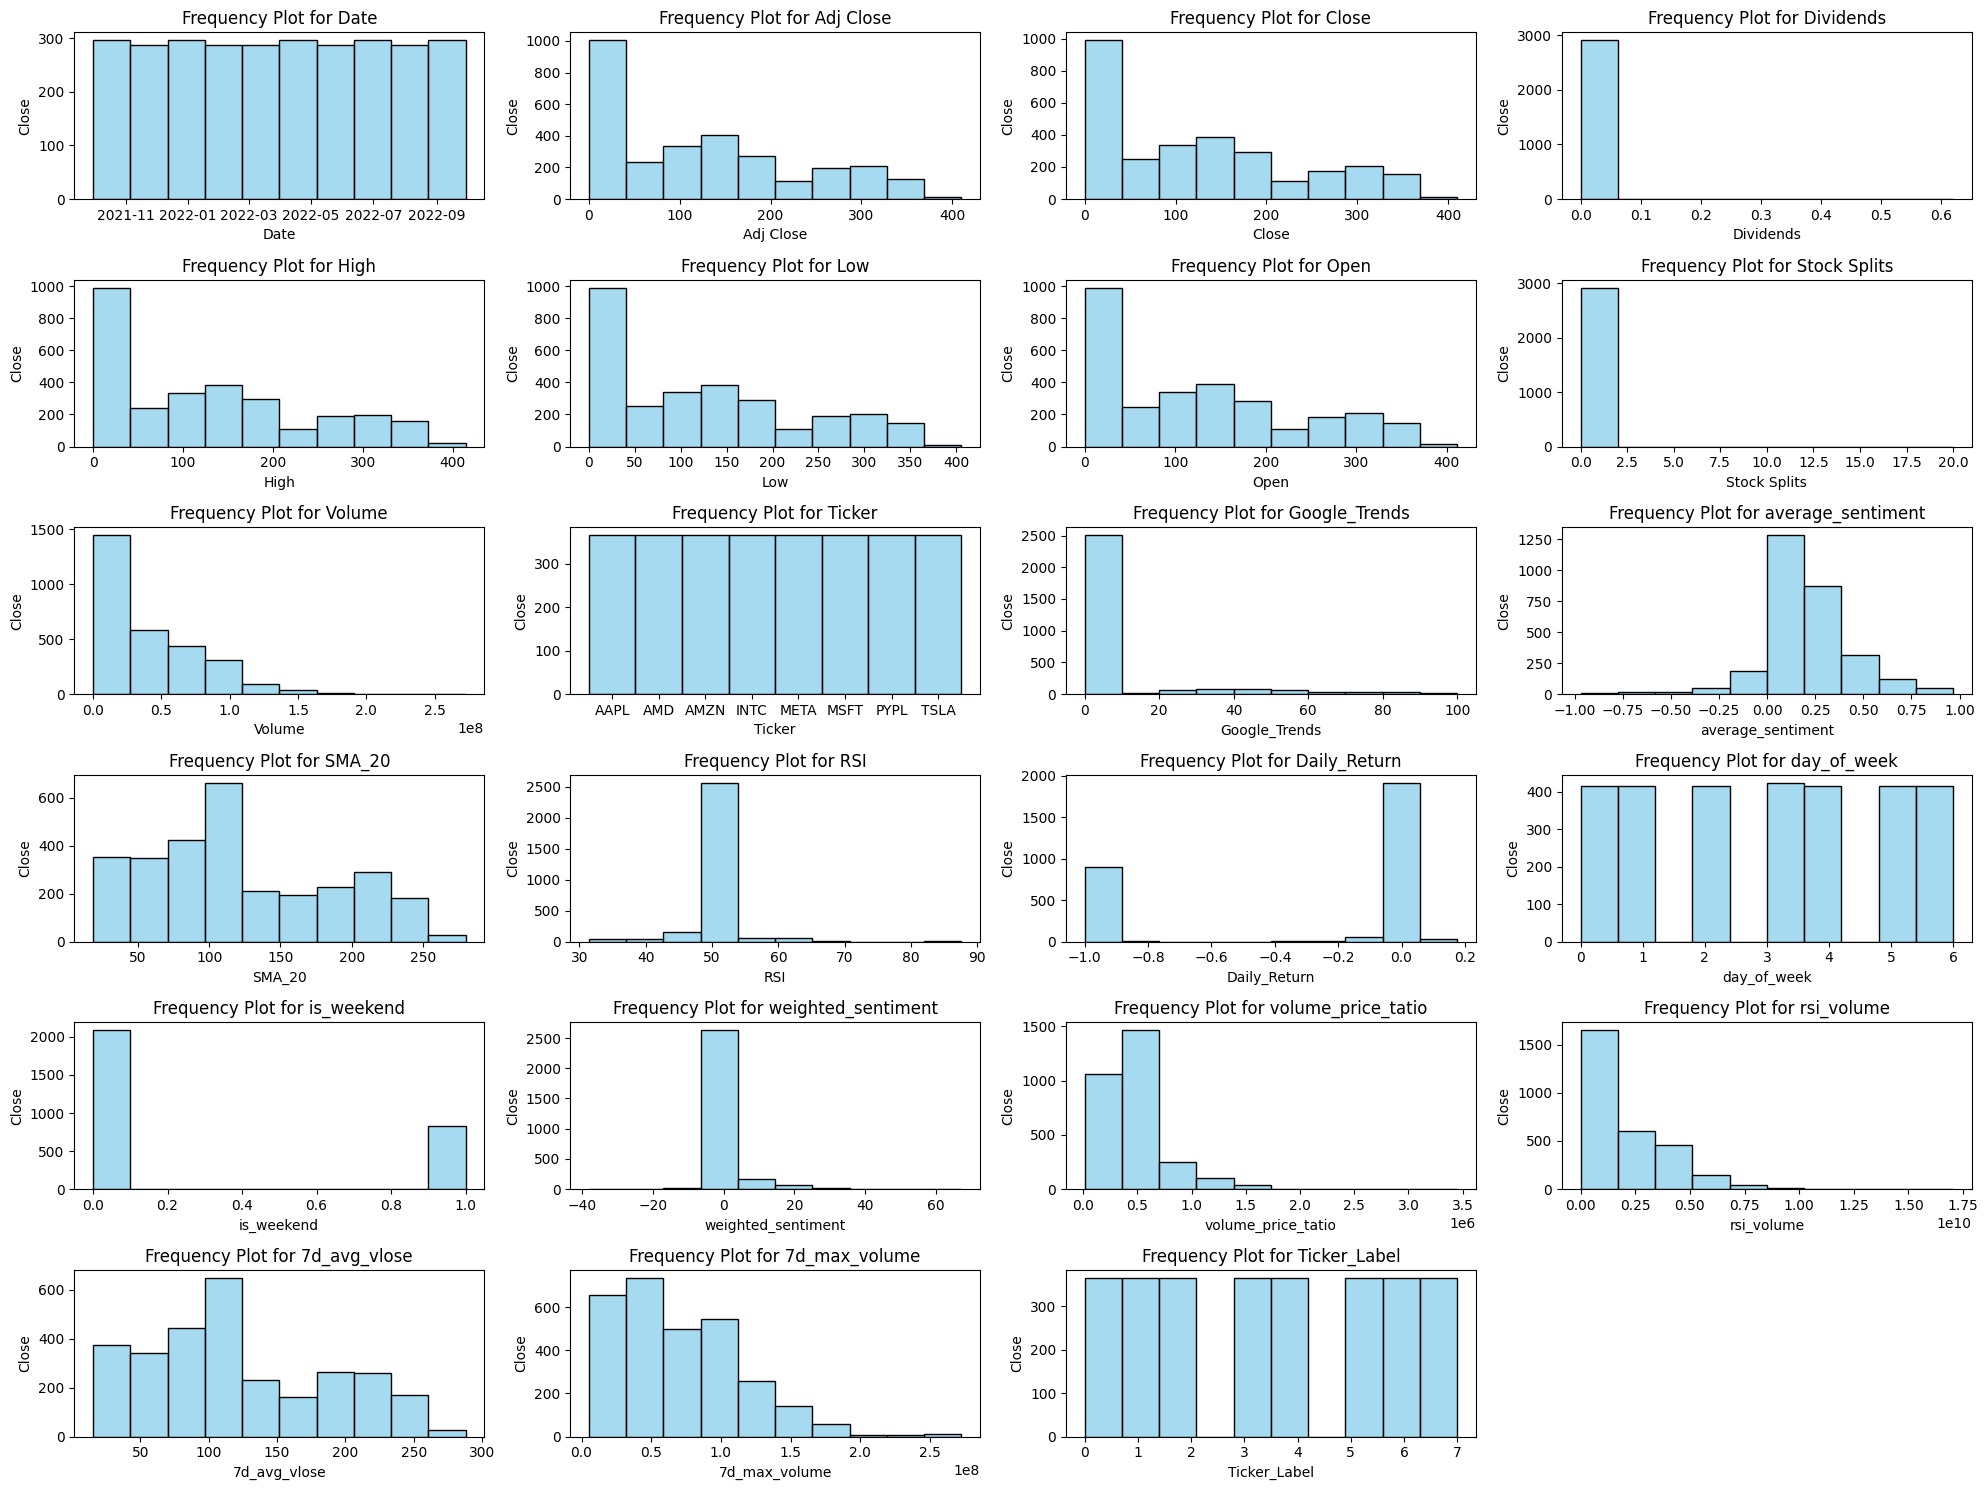

In [1254]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming df_combined_imputed is the DataFrame
# Features to generate frequency plots and tables for
# Filter data for Ticker_Label = 7
#data_tesla = df_stock_data_final_imp[df_stock_data_final_imp['Ticker_Label'] == 7]
data_tesla = df_stock_data_final_imp
features = data_tesla.columns.tolist()
# Set up the number of rows and columns for subplots
n_cols = 4
n_rows = (len(features) + n_cols - 1) // n_cols  # Calculate rows required for given columns
# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()  # Flatten the axes array for easier access
# Plot each feature in a subplot
for i, feature in enumerate(features):
    sns.histplot(data_tesla[feature], kde=False, ax=axes[i], bins=10, color='#87CEEB')
    axes[i].set_title(f"Frequency Plot for {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Close")
# Remove any empty subplots
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])
# Adjust the layout
plt.tight_layout()
plt.show()

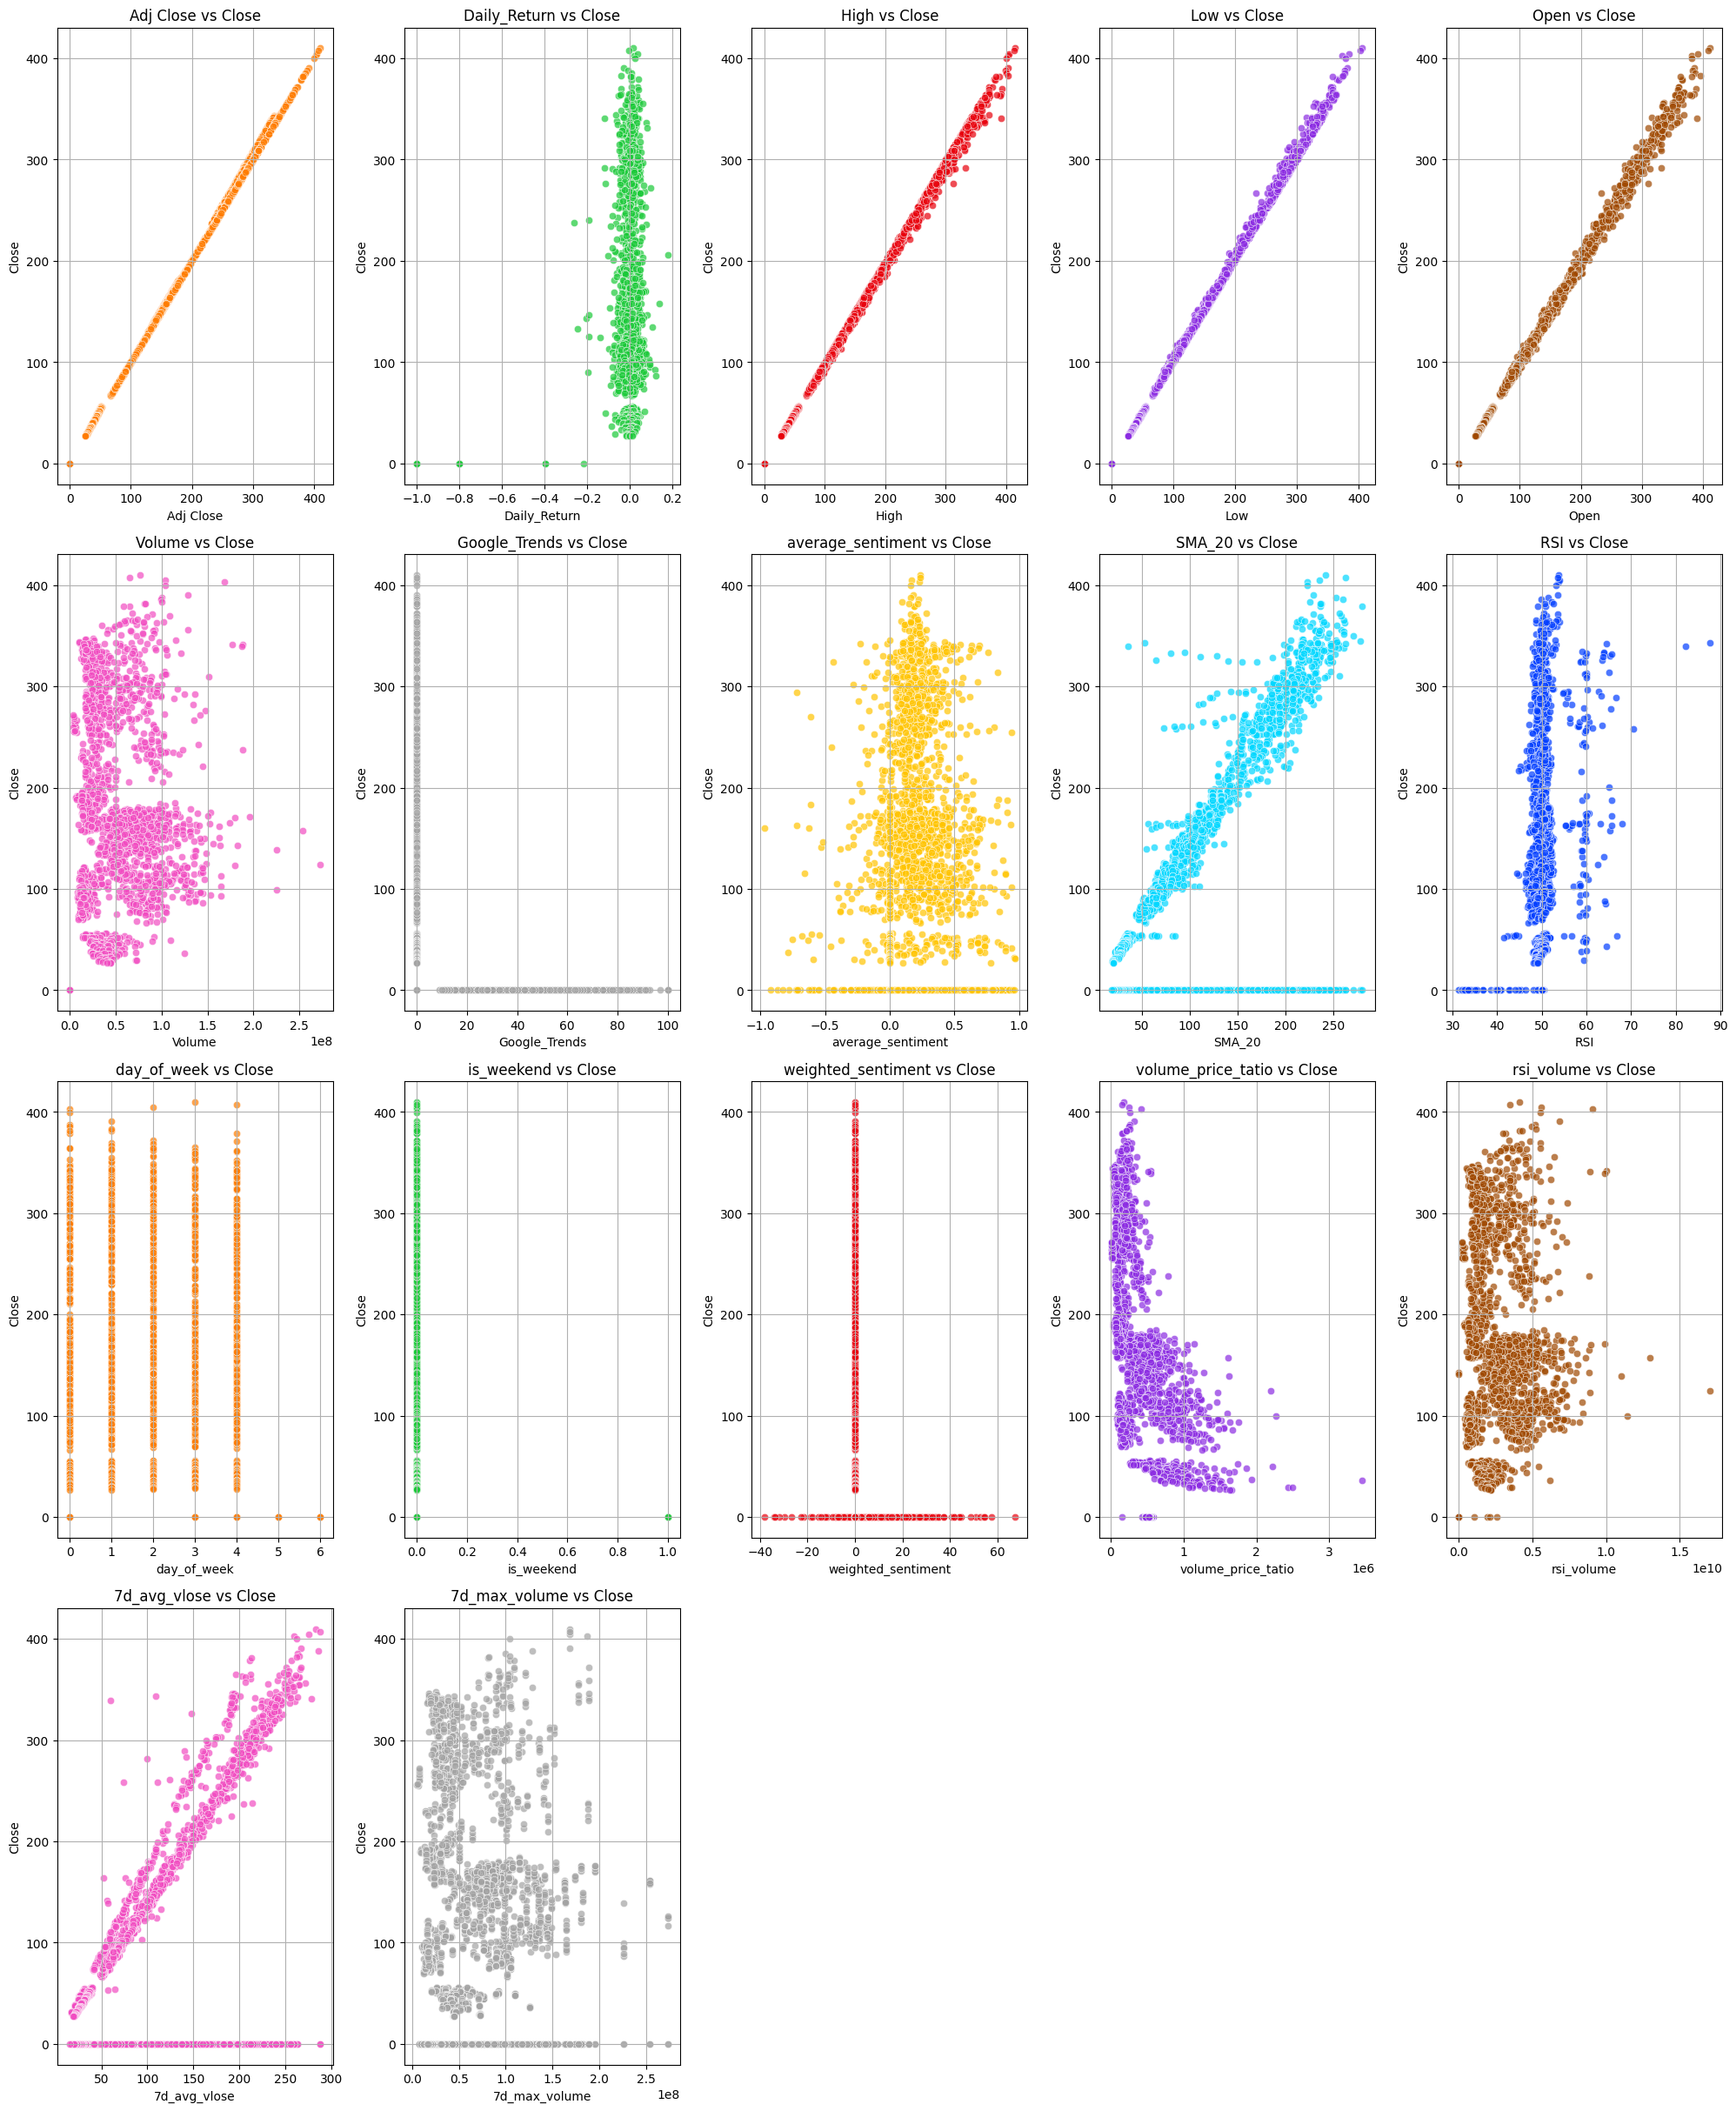

In [1255]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define independent features and the target
independent_features = [
    'Adj Close', 'Daily_Return', 'High', 'Low', 'Open', 
    'Volume', 'Google_Trends', 'average_sentiment', 
    'SMA_20', 'RSI', 'day_of_week','is_weekend',
    'weighted_sentiment',
    'volume_price_tatio',
    'rsi_volume', 
    '7d_avg_vlose',
    '7d_max_volume'
]
target = 'Close'

# Create subplots for each independent feature vs Daily_Return
plt.figure(figsize=(20, 30))  # Adjust figure size to fit all plots
palette = sns.color_palette("bright")  # Use bright color palette

for i, feature in enumerate(independent_features, start=1):
    plt.subplot(5, 5, i)  # Create a 6x2 grid for subplots
    sns.scatterplot(
        x=feature,
        y=target,
        data=data_tesla,
        alpha=0.7,
        color=palette[i % len(palette)]  # Cycle through bright colors
    )
    plt.title(f"{feature} vs {target}")
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.grid(True)

plt.tight_layout()
plt.show()

## <span style="color:#4682B4">Correlation</span>

The **correlation matrix** is a powerful tool used to measure the relationships between independent variables in a dataset. It helps identify how strongly pairs of variables are linearly related to each other. Correlation values range from **-1 to 1**:
- A value close to **1** indicates a strong positive correlation, meaning as one variable increases, the other tends to increase as well.
- A value close to **-1** indicates a strong negative correlation, where one variable increases as the other decreases.
- A value around **0** indicates little to no linear relationship between the variables.

### Importance of the Correlation Matrix:
1. **Identify Multicollinearity**: If two or more independent variables are highly correlated, it can lead to multicollinearity, which can negatively impact the model’s performance. High multicollinearity makes it difficult to determine the individual effect of each variable on the dependent variable.
   
2. **Feature Selection**: By analyzing the correlation matrix, we can detect variables that are redundant or too closely related to others. This helps in deciding which features to retain and which to drop for building a simpler and more efficient model.

3. **Insights into Relationships**: Understanding correlations helps in interpreting the underlying relationships in the data. For example, we can see how features like **temperature** and **atemp** (feels-like temperature) are closely related, which allows us to make more informed decisions on feature engineering and selection.

By using the correlation matrix effectively, we can reduce redundancy in the dataset, improve model performance, and gain insights into the relationships between variables, making it a critical step in the data preprocessing phase.

In [1256]:
# Convert all column names to lowercase
data_tesla.columns = data_tesla.columns.str.lower()

# Display the first few rows to verify the changes
data_tesla.head()

date   adj close       close  dividends        high         low  \
0 2021-09-30  139.016602  141.500000        0.0  144.380005  141.279999   
1 2021-10-01  140.146408  142.649994        0.0  142.919998  139.110001   
2 2021-10-02    0.000000    0.000000        0.0    0.000000    0.000000   
3 2021-10-03    0.000000    0.000000        0.0    0.000000    0.000000   
4 2021-10-04  136.697983  139.139999        0.0  142.210007  138.270004   

         open  stock splits    volume ticker  ...        rsi  daily_return  \
0  143.660004           0.0  89056700   AAPL  ...  48.310594      0.019106   
1  141.899994           0.0  94639600   AAPL  ...  50.000000      0.008127   
2    0.000000           0.0         0   AAPL  ...  48.788001     -1.000000   
3    0.000000           0.0         0   AAPL  ...  49.910417     -0.216160   
4  141.759995           0.0  98322000   AAPL  ...  50.028530      0.006827   

   day_of_week  is_weekend  weighted_sentiment  volume_price_tatio  \
0            3           0               0.000       629375.971731   
1            4           0               0.000       663439.215207   
2            5           1               0.000       152886.813787   
3            6           1              44.415       432352.654079   
4            0           0               0.000       706640.796545   

     rsi_volume  7d_avg_vlose  7d_max_volume  ticker_label  
0  2.709863e+09     56.406286   7.082856e+07             0  
1  0.000000e+00     83.013143   1.194648e+08             0  
2  1.018837e+09    129.706571   3.229456e+07             0  
3  1.906411e+09    121.636322   7.111550e+07             0  
4  2.894815e+09     56.737142   7.399268e+07             0  

[5 rows x 23 columns]

Correlation Matrix:
                    adj close  close  dividends  high   low  open  \
adj close                1.00   1.00       0.04  1.00  1.00  1.00   
close                    1.00   1.00       0.04  1.00  1.00  1.00   
dividends                0.04   0.04       1.00  0.04  0.04  0.04   
high                     1.00   1.00       0.04  1.00  1.00  1.00   
low                      1.00   1.00       0.04  1.00  1.00  1.00   
open                     1.00   1.00       0.04  1.00  1.00  1.00   
stock splits             0.01   0.00      -0.00  0.01  0.00  0.00   
volume                   0.46   0.46       0.00  0.46  0.45  0.46   
google_trends           -0.40  -0.40      -0.02 -0.40 -0.40 -0.40   
average_sentiment        0.05   0.05      -0.02  0.05  0.05  0.05   
sma_20                   0.54   0.54       0.02  0.54  0.54  0.54   
rsi                      0.23   0.23      -0.01  0.23  0.23  0.23   
daily_return             0.73   0.73       0.04  0.73  0.73  0.73   
day_of_week   

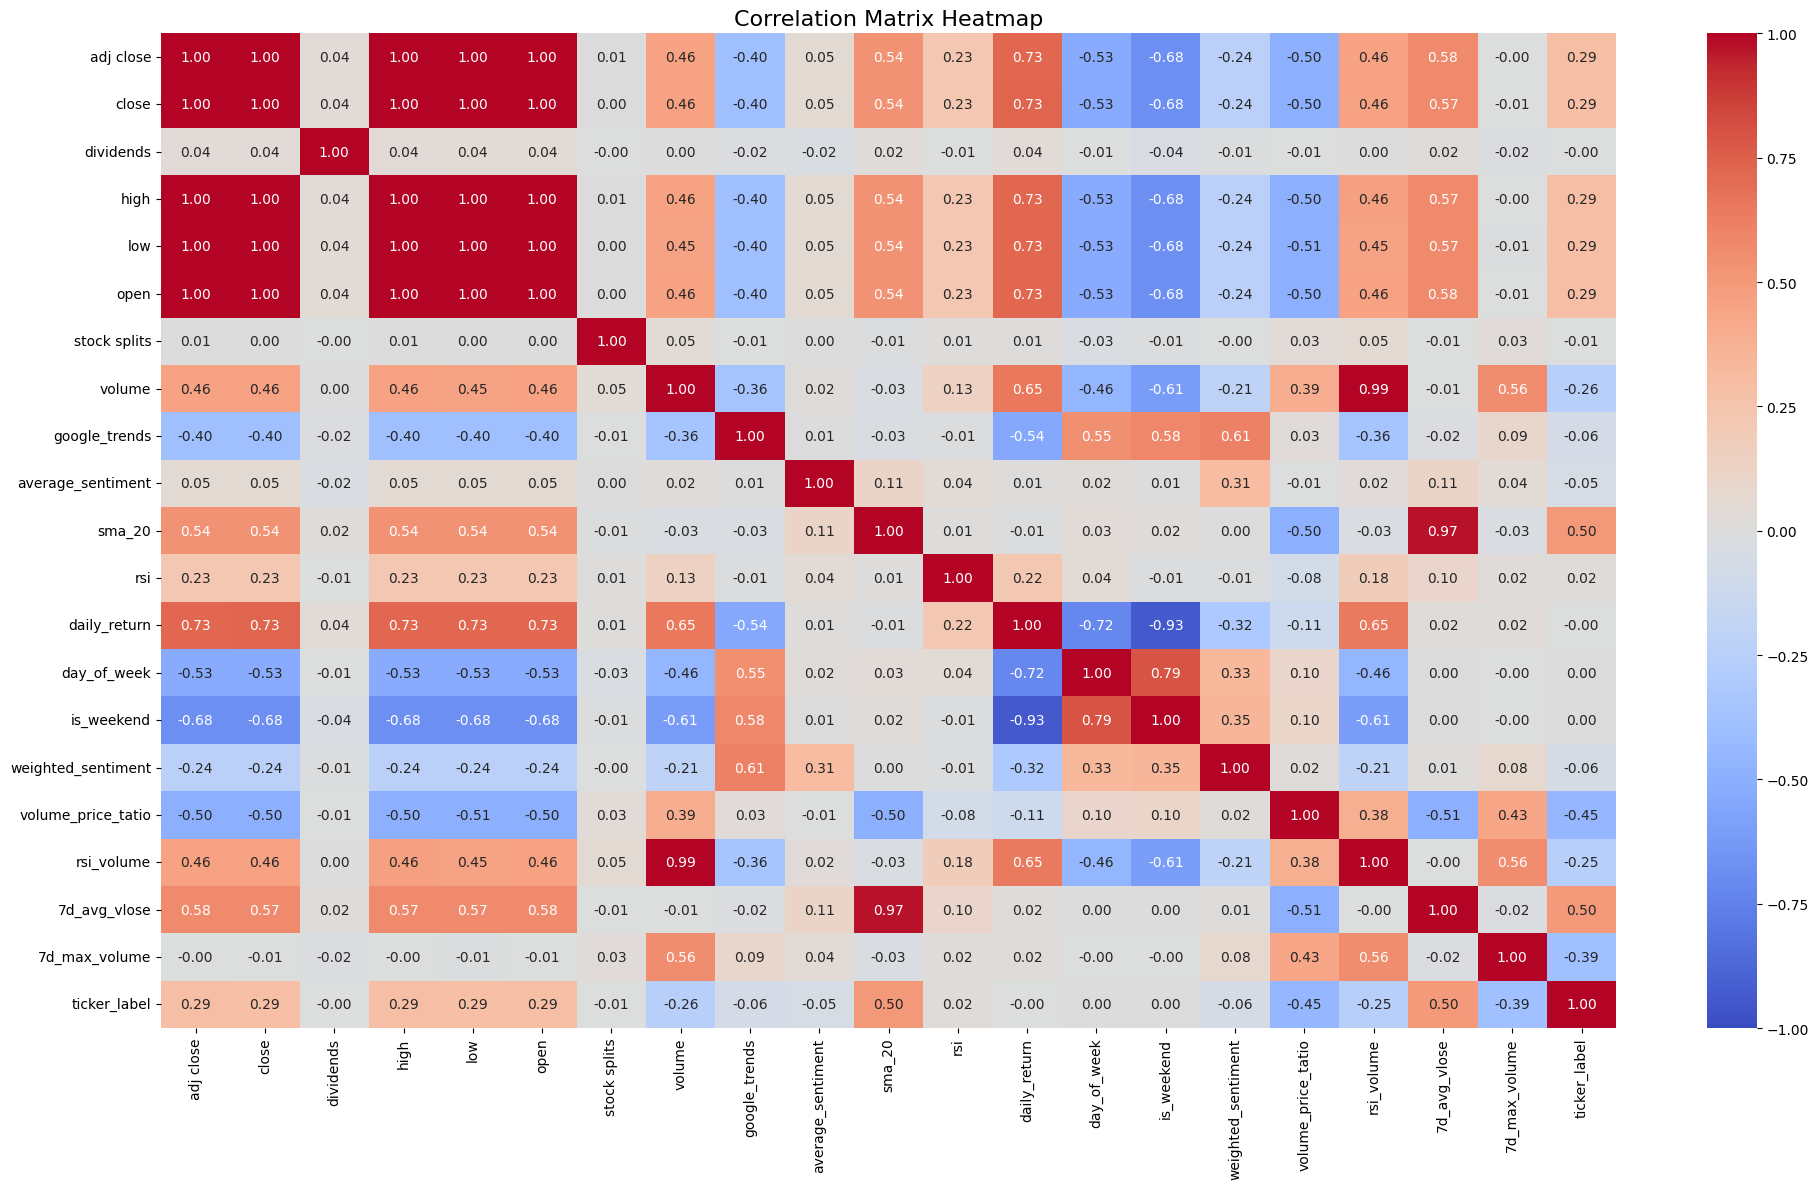

In [1257]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Compute the correlation matrix
# Drop 'Ticker' and 'Date' columns from the DataFrame
data_tesla_cleaned = data_tesla.drop(columns=['ticker', 'date'])
correlation_matrix = data_tesla_cleaned.corr()
# Display the correlation matrix as a table (rounded to 2 decimal places)
print("Correlation Matrix:")
print(correlation_matrix.round(2))
# Plot the heatmap for the correlation matrix
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
# Set the title for the heatmap
plt.title('Correlation Matrix Heatmap', fontsize=16)
# Display the heatmap
plt.tight_layout()
plt.show()

## <span style="color:#4682B4">Key Observations and Recommendations</span>

## Key Observations

### 1. Strong Positive Correlations
| Feature Group         | Correlation with Price Features   | Insights                                                                                  |
|------------------------|------------------------------------|------------------------------------------------------------------------------------------|
| `adj close`, `close`, `high`, `low`, `open` | ≈ 1.00                              | Highly interdependent; redundant information, select one representative feature like `close`. |
| `daily_return`         | 0.73                              | Strongly influenced by price-related features.                                           |
| `sma_20` (20-day moving average) | 0.54                              | Valuable for capturing medium-term trends.                                               |
| `volume` and `rsi_volume` | ≈ 0.46                           | Volume-based metrics contribute to price movements.                                       |

### 2. Negative Correlations
| Feature              | Correlation with Price Features | Insights                                                                              |
|-----------------------|---------------------------------|--------------------------------------------------------------------------------------|
| `google_trends`       | -0.40                          | Suggests search trends increase as prices decline, indicating sentiment-related insights. |
| `day_of_week`         | -0.53                          | Weekly patterns impact market activity.                                              |
| `is_weekend`          | -0.68                          | Weekend effect on stock price trends.                                                |
| `volume_price_tatio`  | -0.50                          | Potential for detecting overbought or oversold conditions.                           |
| `weighted_sentiment`  | -0.24                          | Weak negative correlation, but may add sentiment context.                            |

### 3. Weak or Insignificant Correlations
| Feature             | Correlation  | Insights                                                        |
|----------------------|--------------|-----------------------------------------------------------------|
| `dividends`          | ≈ 0.04       | Insignificant for short-term predictions.                       |
| `stock_splits`       | ≈ 0.00       | Little predictive value.                                        |
| `7d_max_volume`      | ≈ 0.00       | Low relevance for stock price predictions.                      |

---

## Recommendations

### 1. Feature Selection
- **Drop** redundant features: `high`, `low`, and `open` (retain `close` or `adj close` as a representative).
- **Exclude** features with weak correlations: `dividends`, `stock_splits`, and `7d_max_volume`.
- **Retain** features with meaningful dynamics: `daily_return`, `sma_20`, `rsi_volume`, and `volume_price_tatio`.

### 2. Feature Transformation
- Create **lagged features** for `google_trends`, `volume`, and `daily_return` to capture temporal dependencies.
- Use **moving averages** for `volume` and `weighted_sentiment` to smooth short-term volatility and highlight trends.

### 3. Sentiment Features
- Investigate the relationship between `google_trends` and stock prices. Combine with `average_sentiment` or `weighted_sentiment` to uncover hidden patterns.

### 4. Time-Based Features
- Retain **`day_of_week`** and **`is_weekend`** to capture weekly seasonality effects in stock price movements.

### 5. Dimensionality Reduction
- Apply **PCA** to combine highly correlated features (e.g., price-related features) into fewer components while retaining variance.

### 6. Multicollinearity Handling
- Use **Ridge Regression** or **Lasso Regression** to mitigate multicollinearity caused by strongly correlated features.

---

## Conclusion
Focus on retaining features with strong or moderate correlations while engineering temporal and aggregated features (e.g., moving averages, lagged features). Remove features with weak correlations to simplify the model and improve interpretability. Sentiment-based features (`google_trends` and `weighted_sentiment`) could be valuable for identifying market sentiment and its impact on price trends.

## <span style="color:#4682B4">Importance of StandardScaler and PCA</span>

### StandardScaler
**StandardScaler** is a preprocessing technique used to standardize features by removing the mean and scaling them to unit variance. It ensures that each feature contributes equally to the model and prevents bias toward features with larger values. Here’s why it’s important:

1. **Normalization of Features**:
   - Different features in the dataset may have varying scales. For example, temperature may be measured in degrees, while wind speed is measured in meters per second. Without scaling, features with larger values might dominate the learning process, leading to biased predictions.
   
2. **Model Performance**:
   - Many machine learning algorithms, especially those that use distance metrics (like **k-nearest neighbors** or **support vector machines**), perform better when features are on a similar scale. **StandardScaler** ensures that all features contribute equally to the model.

3. **Stability of Coefficients**:
   - Scaling improves the stability of the model coefficients, especially in models like **linear regression** and **logistic regression**, where coefficients represent the influence of each feature on the target variable. Unscaled features may lead to large coefficients, which are harder to interpret and can cause overfitting.

---

### Principal Component Analysis (PCA)
**Principal Component Analysis (PCA)** is a dimensionality reduction technique that transforms the original set of features into a new set of uncorrelated features, called **principal components**. These components capture the most important information from the original features. Here’s why PCA is important:

1. **Reducing Dimensionality**:
   - High-dimensional datasets can be difficult to work with and can lead to overfitting. PCA helps by reducing the number of features while retaining as much variance (information) as possible. This simplifies the dataset and improves model efficiency.

2. **Eliminating Redundancy**:
   - PCA helps in eliminating multicollinearity by creating new, uncorrelated features (principal components). This is particularly useful when the original features are highly correlated, as PCA focuses on capturing the most meaningful information from the data.

3. **Improving Computational Efficiency**:
   - By reducing the dimensionality of the dataset, PCA reduces the computational burden on machine learning algorithms, especially for large datasets. This leads to faster training and prediction times without sacrificing much accuracy.

4. **Visualizing High-Dimensional Data**:
   - PCA allows us to visualize high-dimensional data in 2D or 3D, making it easier to understand patterns and relationships in the data that would otherwise be difficult to interpret.

By using **StandardScaler** and **PCA** together, we can ensure that the dataset is properly scaled and that only the most important features are retained for model training, leading to a more efficient and accurate predictive model.

In [1263]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define the features to combine (price-related features)
price_features = ['adj close', 'close', 'high', 'low', 'open']
non_price_features = ['dividends', 'stock splits', 'volume', 'google_trends', 
                      'average_sentiment', 'sma_20', 'rsi', 'daily_return', 
                      'day_of_week', 'is_weekend', 'weighted_sentiment', 
                      'volume_price_tatio', 'rsi_volume', '7d_avg_vlose', '7d_max_volume','ticker_label']

# Separate the price-related features
price_data = data_tesla[price_features]

# Standardize the price-related features
scaler = StandardScaler()
price_data_scaled = scaler.fit_transform(price_data)

# Apply PCA to combine price-related features
pca = PCA(n_components=2)  # Retain 2 principal components
price_pca = pca.fit_transform(price_data_scaled)

# Create a DataFrame for the PCA components
price_pca_df = pd.DataFrame(price_pca, columns=['price_pc1', 'price_pc2'])

# Concatenate the PCA components with the remaining features
non_price_data = data_tesla[non_price_features]
data_tesla_pca = pd.concat([non_price_data.reset_index(drop=True), price_pca_df.reset_index(drop=True)], axis=1)

# Display the explained variance ratio for PCA components
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio for Price Components:")
for i, var in enumerate(explained_variance_ratio, start=1):
    print(f"Price_PC{i}: {var:.4f}")

# Show the first few rows of the transformed DataFrame
data_tesla_pca.tail()

Explained Variance Ratio for Price Components:
Price_PC1: 0.9996
Price_PC2: 0.0002


dividends  stock splits    volume  google_trends  average_sentiment  \
2915        0.0           0.0         0             38           0.150072   
2916        0.0           0.0  58076900              0           0.114828   
2917        0.0           0.0  61925200              0           0.225460   
2918        0.0           0.0  54664800              0           0.129845   
2919        0.0           0.0         0              0           0.057709   

          sma_20        rsi  daily_return  day_of_week  is_weekend  \
2915  206.792001  50.000000     -1.000000            6           1   
2916  206.871501  48.837380      0.005489            0           0   
2917  206.833501  49.622261      0.025108            1           0   
2918  206.761000  49.388855      0.017212            2           0   
2919  191.777000  39.858165     -1.000000            3           0   

      weighted_sentiment  volume_price_tatio    rsi_volume  7d_avg_vlose  \
2915            5.702744       479121.859469  0.000000e+00    211.788570   
2916            0.000000       210415.919514  2.836324e+09    207.065713   
2917            0.000000       218863.361369  3.072868e+09    203.381426   
2918            0.000000       189933.638385  2.699832e+09    201.525713   
2919            0.000000       523039.366003  0.000000e+00    160.298571   

      7d_max_volume  ticker_label  price_pc1  price_pc2  
2915     70545400.0             7  -2.411938  -0.000751  
2916     70545400.0             7   3.061281  -0.034507  
2917     70545400.0             7   3.210962  -0.007681  
2918     70545400.0             7   3.248263  -0.054450  
2919     63748400.0             7  -2.411938  -0.000751

Correlation Matrix:
                    dividends  stock splits  volume  google_trends  \
dividends                1.00         -0.00    0.00          -0.02   
stock splits            -0.00          1.00    0.05          -0.01   
volume                   0.00          0.05    1.00          -0.36   
google_trends           -0.02         -0.01   -0.36           1.00   
average_sentiment       -0.02          0.00    0.02           0.01   
sma_20                   0.02         -0.01   -0.03          -0.03   
rsi                     -0.01          0.01    0.13          -0.01   
daily_return             0.04          0.01    0.65          -0.54   
day_of_week             -0.01         -0.03   -0.46           0.55   
is_weekend              -0.04         -0.01   -0.61           0.58   
weighted_sentiment      -0.01         -0.00   -0.21           0.61   
volume_price_tatio      -0.01          0.03    0.39           0.03   
rsi_volume               0.00          0.05    0.99          -0.36   


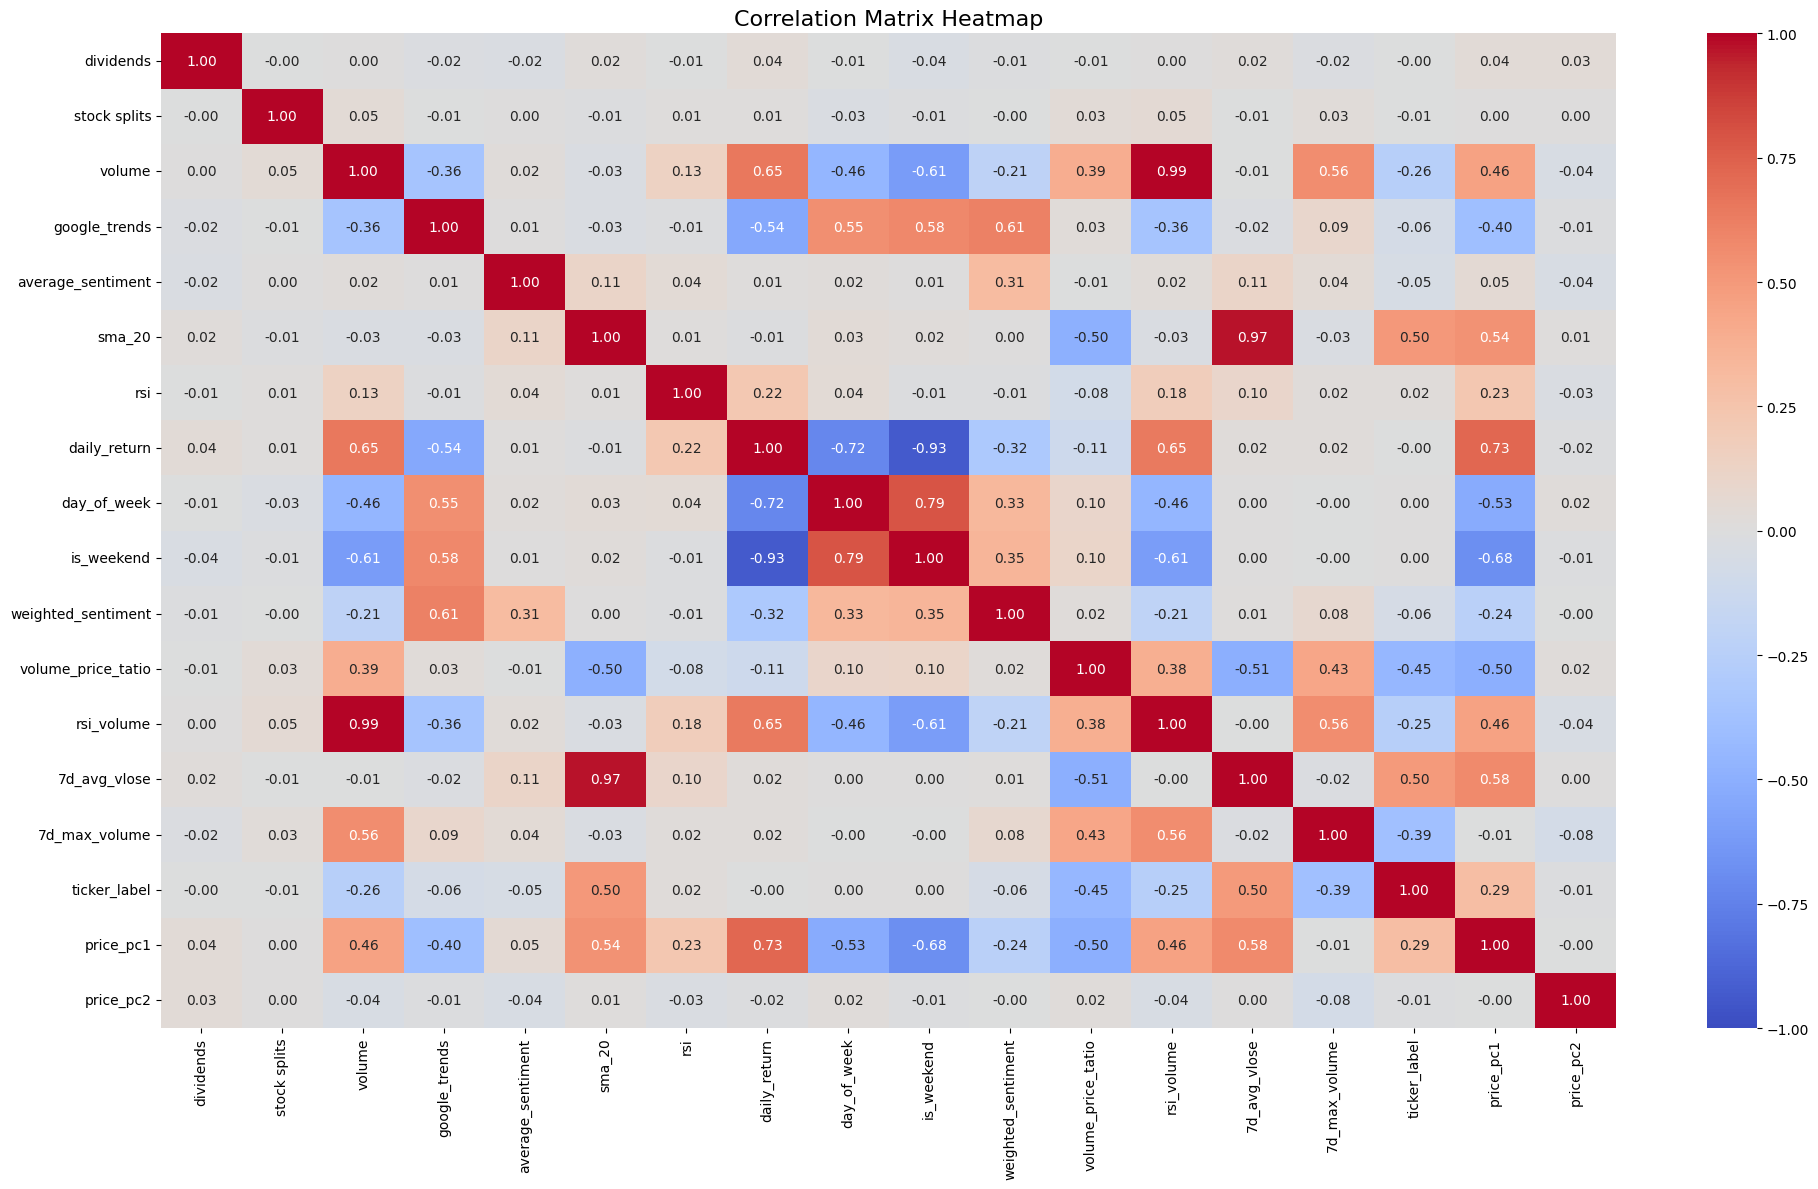

In [1264]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Compute the correlation matrix
# Drop 'Ticker' and 'Date' columns from the DataFrame
#data_tesla_cleaned = data_tesla_pca.drop(columns=['ticker', 'date'])
correlation_matrix = data_tesla_pca.corr()
# Display the correlation matrix as a table (rounded to 2 decimal places)
print("Correlation Matrix:")
print(correlation_matrix.round(2))
# Plot the heatmap for the correlation matrix
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
# Set the title for the heatmap
plt.title('Correlation Matrix Heatmap', fontsize=16)
# Display the heatmap
plt.tight_layout()
plt.show()

In [1265]:

data_tesla_pca.head()

dividends  stock splits    volume  google_trends  average_sentiment  \
0        0.0           0.0  89056700              0           0.098900   
1        0.0           0.0  94639600              0           0.248255   
2        0.0           0.0         0              0           0.007525   
3        0.0           0.0         0             54           0.822500   
4        0.0           0.0  98322000              0           0.122830   

       sma_20        rsi  daily_return  day_of_week  is_weekend  \
0   62.567100  48.310594      0.019106            3           0   
1   82.420900  50.000000      0.008127            4           0   
2  127.155200  48.788001     -1.000000            5           1   
3  121.489088  49.910417     -0.216160            6           1   
4   54.328900  50.028530      0.006827            0           0   

   weighted_sentiment  volume_price_tatio    rsi_volume  7d_avg_vlose  \
0               0.000       629375.971731  2.709863e+09     56.406286   
1               0.000       663439.215207  0.000000e+00     83.013143   
2               0.000       152886.813787  1.018837e+09    129.706571   
3              44.415       432352.654079  1.906411e+09    121.636322   
4               0.000       706640.796545  2.894815e+09     56.737142   

   7d_max_volume  ticker_label  price_pc1  price_pc2  
0   7.082856e+07             0   0.407088   0.021503  
1   1.194648e+08             0   0.394743  -0.003934  
2   3.229456e+07             0  -2.411938  -0.000751  
3   7.111550e+07             0  -2.411938  -0.000751  
4   7.399268e+07             0   0.360324   0.023649

Processing stock: AAPL
Training LSTM model for stock: AAPL
Epoch 1/50


/opt/anaconda3/envs/tejusdvscode/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/envs/tejusdvscode/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.4056 - val_loss: 0.2448
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2042 - val_loss: 0.2160
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1945 - val_loss: 0.2109
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1915 - val_loss: 0.2257
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1785 - val_loss: 0.2035
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1729 - val_loss: 0.2030
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1736 - val_loss: 0.1916
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1646 - val_loss: 0.1868
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1432 - val_loss: 0.1663
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1412 - val_loss: 0.1511
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1292 - val_loss: 0.1293
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1100 - val_loss: 0.1071
Epoch 13/50
9/9 ━━━━━━━

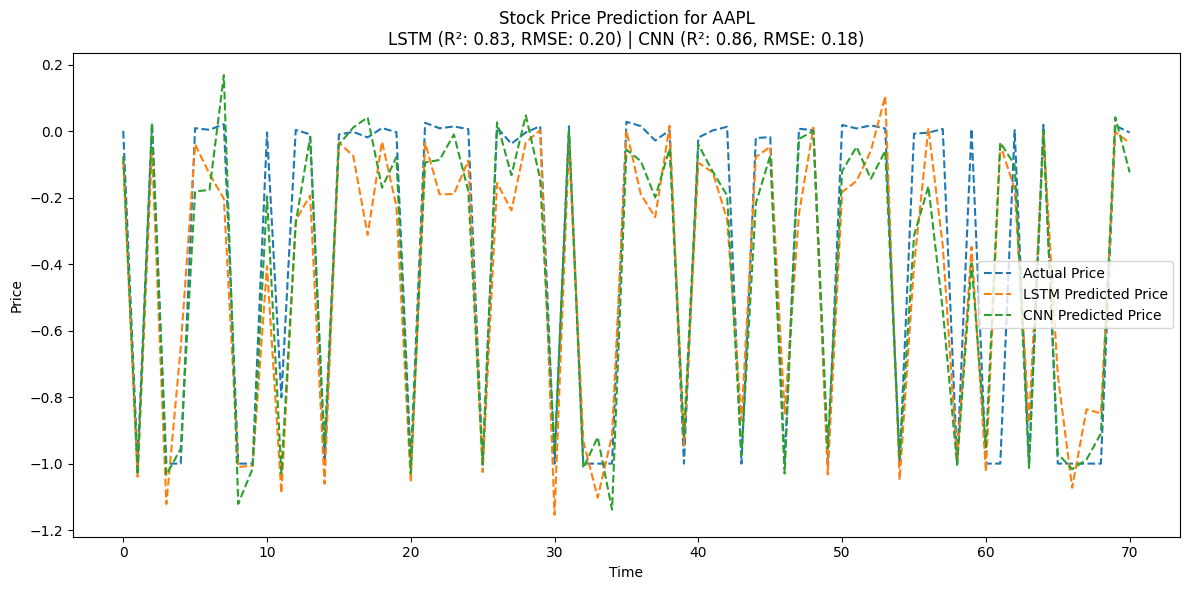

Processing stock: AMD
Training LSTM model for stock: AMD
Epoch 1/50


/opt/anaconda3/envs/tejusdvscode/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/envs/tejusdvscode/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.3754 - val_loss: 0.2598
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2195 - val_loss: 0.2010
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1799 - val_loss: 0.2005
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1751 - val_loss: 0.2000
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1829 - val_loss: 0.1900
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1576 - val_loss: 0.1886
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1614 - val_loss: 0.1781
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1404 - val_loss: 0.1704
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1540 - val_loss: 0.1660
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1311 - val_loss: 0.1507
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1301 - val_loss: 0.1356
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1089 - val_loss: 0.1113
Epoch 13/50
9/9 ━━━━━━━

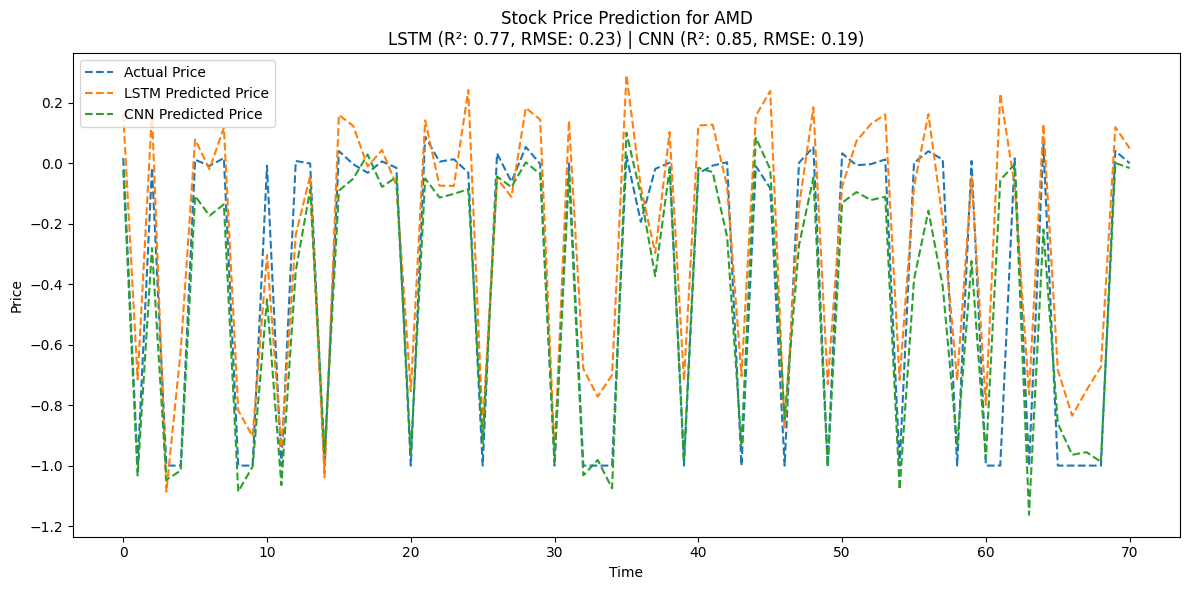

Processing stock: AMZN
Training LSTM model for stock: AMZN
Epoch 1/50


/opt/anaconda3/envs/tejusdvscode/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/envs/tejusdvscode/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.3225 - val_loss: 0.2223
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1998 - val_loss: 0.1886
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1747 - val_loss: 0.1871
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1697 - val_loss: 0.1965
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1647 - val_loss: 0.1845
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1626 - val_loss: 0.1761
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1557 - val_loss: 0.1790
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1452 - val_loss: 0.1659
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1256 - val_loss: 0.1562
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1329 - val_loss: 0.1487
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1134 - val_loss: 0.1208
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1064 - val_loss: 0.0973
Epoch 13/50
9/9 ━━━━━━━

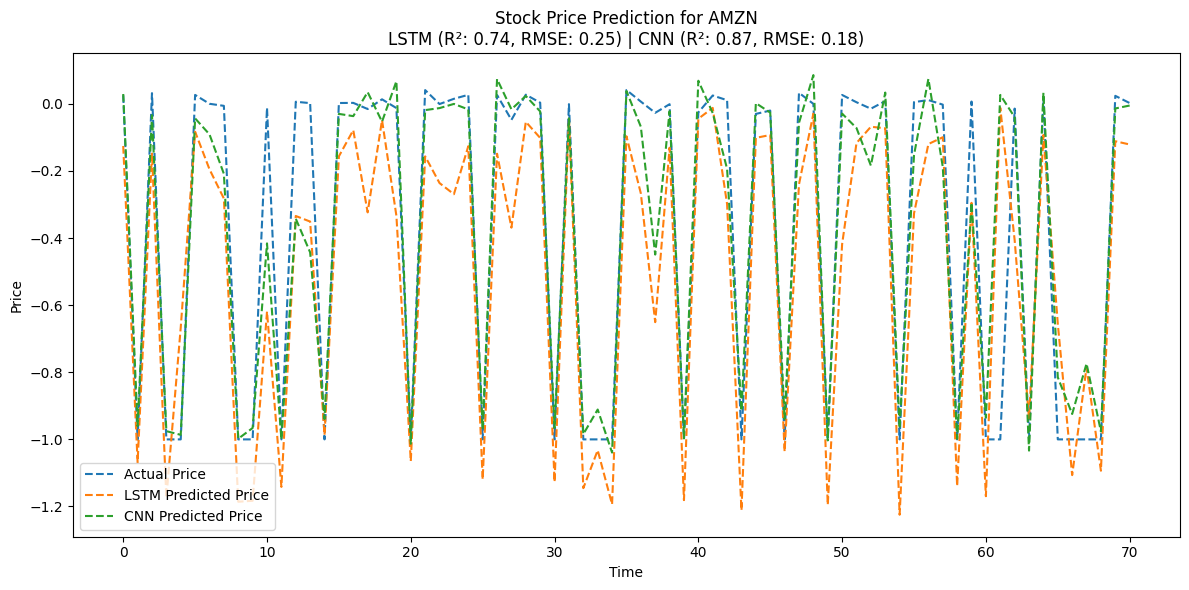

Processing stock: INTC
Training LSTM model for stock: INTC
Epoch 1/50


/opt/anaconda3/envs/tejusdvscode/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/envs/tejusdvscode/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4064 - val_loss: 0.2262
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2069 - val_loss: 0.2147
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1953 - val_loss: 0.2095
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1957 - val_loss: 0.2176
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1767 - val_loss: 0.2007
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1762 - val_loss: 0.1969
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1696 - val_loss: 0.1849
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1551 - val_loss: 0.1669
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1476 - val_loss: 0.1425
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1281 - val_loss: 0.1122
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1040 - val_loss: 0.1126
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0892 - val_loss: 0.0844
Epoch 13/50
9/9 ━━━━━━━

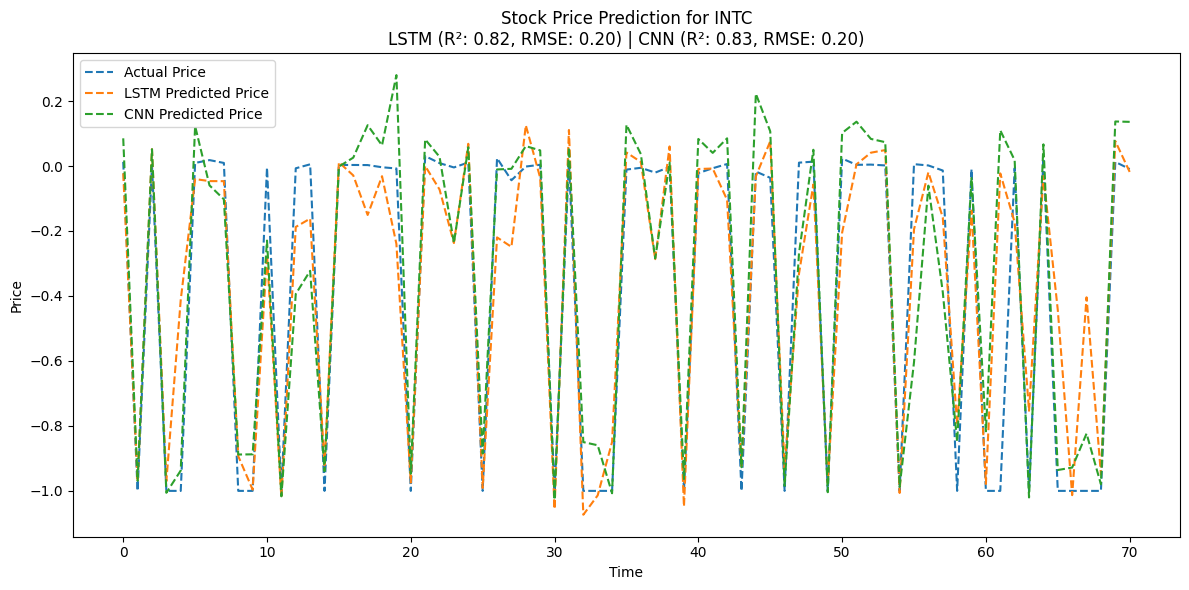

Processing stock: META
Training LSTM model for stock: META
Epoch 1/50


/opt/anaconda3/envs/tejusdvscode/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/envs/tejusdvscode/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.3567 - val_loss: 0.1984
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1877 - val_loss: 0.1821
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1650 - val_loss: 0.1735
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1477 - val_loss: 0.1823
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1487 - val_loss: 0.1644
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1335 - val_loss: 0.1627
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1328 - val_loss: 0.1563
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1272 - val_loss: 0.1467
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1263 - val_loss: 0.1418
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1201 - val_loss: 0.1208
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0956 - val_loss: 0.0990
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0852 - val_loss: 0.0989
Epoch 13/50
9/9 ━━━━━━━

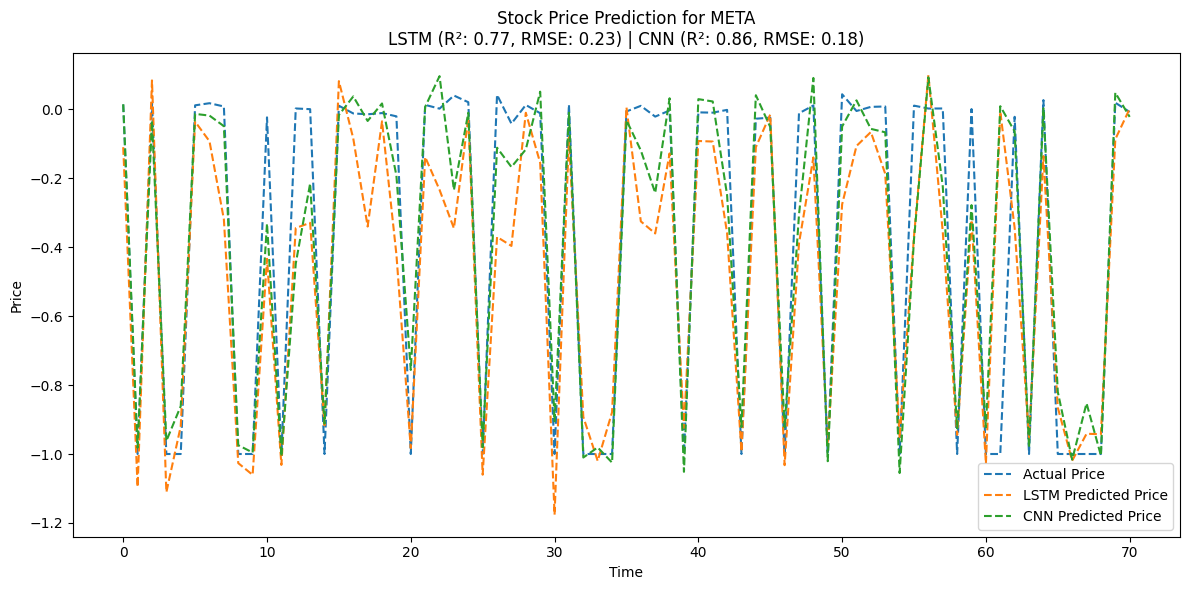

Processing stock: MSFT
Training LSTM model for stock: MSFT
Epoch 1/50


/opt/anaconda3/envs/tejusdvscode/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/envs/tejusdvscode/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.4215 - val_loss: 0.2358
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2182 - val_loss: 0.2061
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1930 - val_loss: 0.2050
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1882 - val_loss: 0.2144
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1723 - val_loss: 0.2020
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1830 - val_loss: 0.1987
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1620 - val_loss: 0.1960
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1671 - val_loss: 0.1883
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1693 - val_loss: 0.1874
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1617 - val_loss: 0.1741
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1468 - val_loss: 0.1610
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1379 - val_loss: 0.1482
Epoch 13/50
9/9 ━━━━━━━

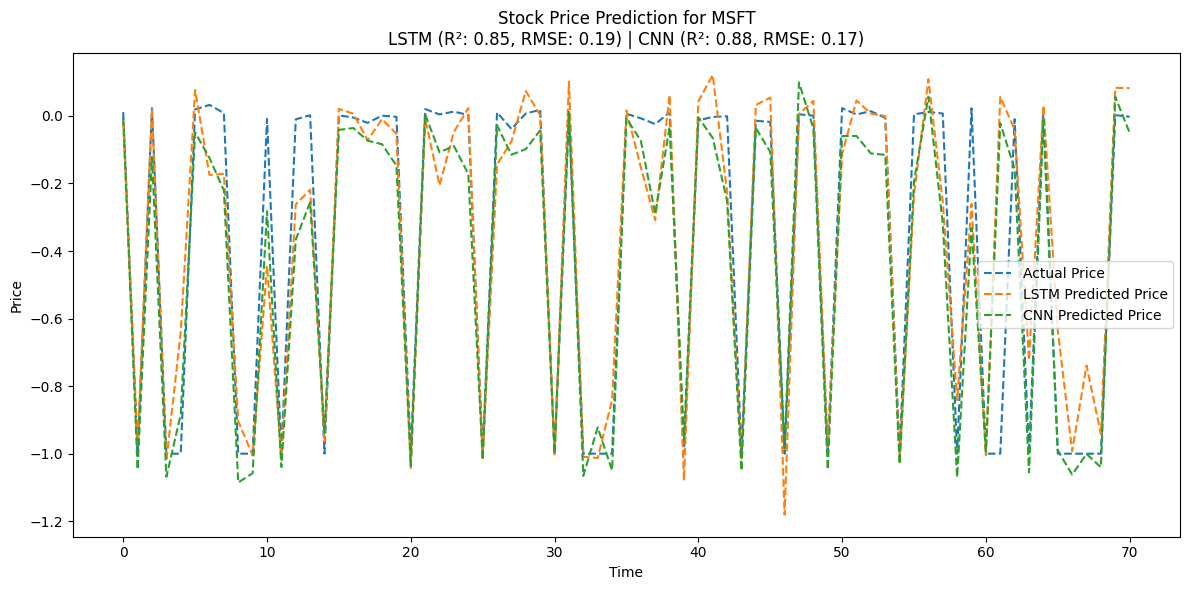

Processing stock: PYPL
Training LSTM model for stock: PYPL
Epoch 1/50


/opt/anaconda3/envs/tejusdvscode/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/envs/tejusdvscode/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.4298 - val_loss: 0.2007
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1887 - val_loss: 0.2042
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1647 - val_loss: 0.1906
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1703 - val_loss: 0.1918
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1720 - val_loss: 0.1858
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1742 - val_loss: 0.1851
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1599 - val_loss: 0.1801
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1641 - val_loss: 0.1773
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1448 - val_loss: 0.1691
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1485 - val_loss: 0.1653
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1334 - val_loss: 0.1508
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1301 - val_loss: 0.1325
Epoch 13/50
9/9 ━━━━━━━

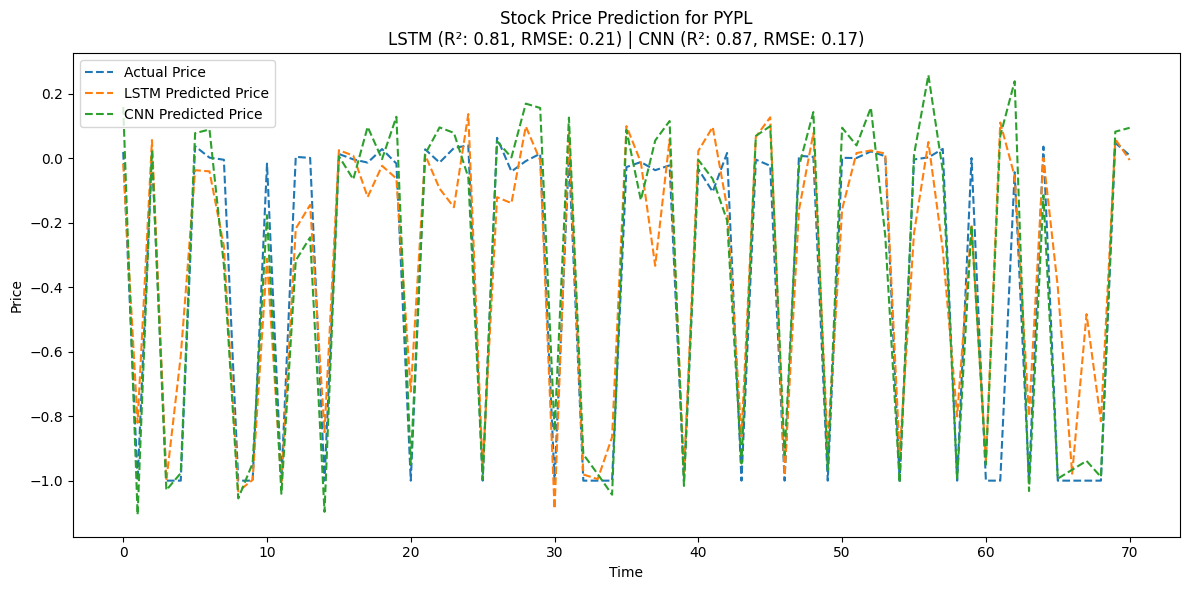

Processing stock: TSLA
Training LSTM model for stock: TSLA
Epoch 1/50


/opt/anaconda3/envs/tejusdvscode/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/envs/tejusdvscode/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - loss: 0.5127 - val_loss: 0.2540
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2250 - val_loss: 0.2501
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1952 - val_loss: 0.2087
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1868 - val_loss: 0.2092
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1837 - val_loss: 0.2034
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1736 - val_loss: 0.1936
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1733 - val_loss: 0.1940
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1613 - val_loss: 0.1795
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1631 - val_loss: 0.1762
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1522 - val_loss: 0.1588
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1429 - val_loss: 0.1489
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1281 - val_loss: 0.1353
Epoch 13/50
9/9 ━━━━━

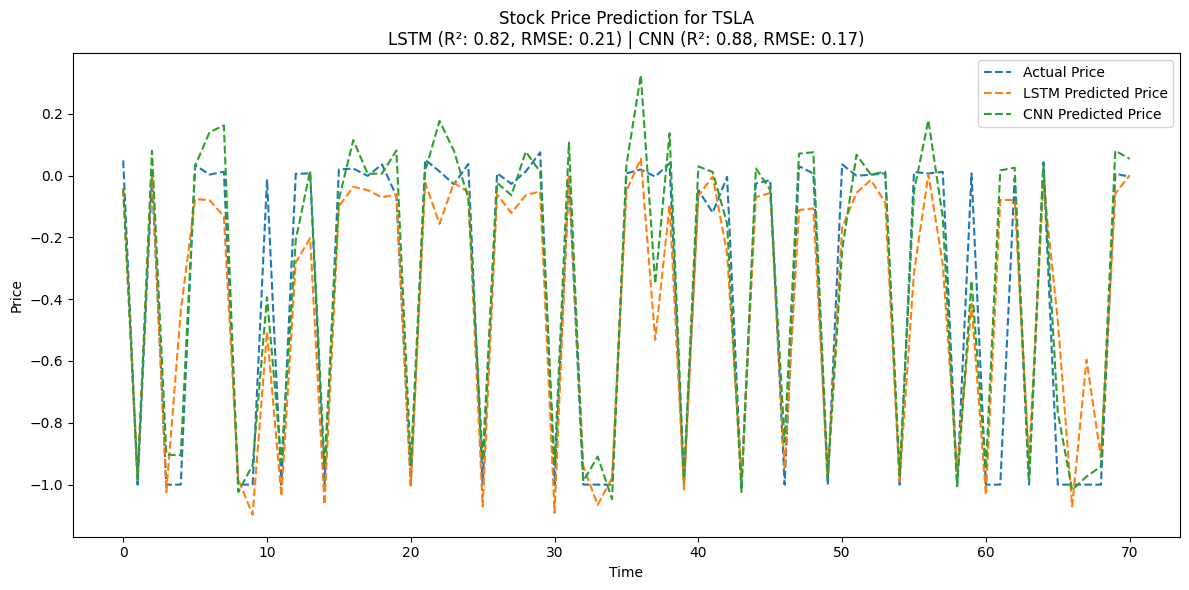

  Stock   LSTM_R²  LSTM_RMSE    CNN_R²  CNN_RMSE
0  AAPL  0.827091   0.199794  0.864600  0.176800
1   AMD  0.766901   0.233401  0.849836  0.187334
2  AMZN  0.735069   0.249495  0.868104  0.176040
3  INTC  0.821395   0.203797  0.829994  0.198831
4  META  0.774166   0.229510  0.862751  0.178921
5  MSFT  0.846893   0.189106  0.878683  0.168332
6  PYPL  0.809136   0.210821  0.870781  0.173466
7  TSLA  0.817152   0.207399  0.875267  0.171297


In [1268]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, Flatten
import matplotlib.pyplot as plt

# Placeholder for results
results = []

# Load the dataset (ensure `data_tesla` is defined)
merged_df = data_tesla_pca
# Clean and standardize column names
merged_df.columns = merged_df.columns.str.strip().str.lower()
# Group by each stock
grouped_stocks = merged_df.groupby('ticker_label')

# Iterate through each stock group
for stock_label, stock_data in grouped_stocks:
    stock_name = tickers[stock_label]  # Map stock_label to the corresponding ticker
    print(f"Processing stock: {stock_name}")
    
    # Filter and select relevant columns
    features = ['average_sentiment', 'price_pc1', 'price_pc2', 'volume', 'sma_20', 'rsi', 'google_trends', 'daily_return',
                'day_of_week', 'is_weekend', 'weighted_sentiment', 'volume_price_tatio', 'rsi_volume', '7d_avg_vlose', '7d_max_volume']  # Input features
    target = 'daily_return'  # Target variable
    stock_data = stock_data[features + [target]].dropna()
    if len(stock_data) < 20:  # Skip if there's not enough data
        print(f"Not enough data for stock {stock_name}. Skipping...")
        continue
    
    # Normalize the data using MinMaxScaler
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(stock_data)
    normalized_df = pd.DataFrame(normalized_data, columns=features + [target])
    
    # Create sequences for LSTM and CNN
    timesteps = 10
    X, y = [], []
    for i in range(timesteps, len(normalized_df)):
        X.append(normalized_df.iloc[i-timesteps:i, :-1].values)
        y.append(normalized_df.iloc[i, -1])
    X, y = np.array(X), np.array(y)
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define the LSTM model
    lstm_model = Sequential([
        LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    
    # Define the CNN model
    cnn_model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    cnn_model.compile(optimizer='adam', loss='mse')
    
    # Train both models
    print(f"Training LSTM model for stock: {stock_name}")
    lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    
    print(f"Training CNN model for stock: {stock_name}")
    cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    
    # Make predictions for both models
    lstm_y_pred = lstm_model.predict(X_test)
    cnn_y_pred = cnn_model.predict(X_test)
    
    lstm_y_pred_original = scaler.inverse_transform(
        np.concatenate((np.zeros((lstm_y_pred.shape[0], len(features))), lstm_y_pred), axis=1)
    )[:, -1]
    cnn_y_pred_original = scaler.inverse_transform(
        np.concatenate((np.zeros((cnn_y_pred.shape[0], len(features))), cnn_y_pred), axis=1)
    )[:, -1]
    y_test_original = scaler.inverse_transform(
        np.concatenate((np.zeros((y_test.shape[0], len(features))), y_test.reshape(-1, 1)), axis=1)
    )[:, -1]
    
    # Calculate R² and RMSE for both models
    lstm_r2 = r2_score(y_test_original, lstm_y_pred_original)
    lstm_rmse = np.sqrt(mean_squared_error(y_test_original, lstm_y_pred_original))
    
    cnn_r2 = r2_score(y_test_original, cnn_y_pred_original)
    cnn_rmse = np.sqrt(mean_squared_error(y_test_original, cnn_y_pred_original))
    
    results.append({
        'Stock': stock_name,
        'LSTM_R²': lstm_r2,
        'LSTM_RMSE': lstm_rmse,
        'CNN_R²': cnn_r2,
        'CNN_RMSE': cnn_rmse
    })
    
    # Plot the results side-by-side
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_original, label='Actual Price', linestyle='--')
    plt.plot(lstm_y_pred_original, label='LSTM Predicted Price', linestyle='--')
    plt.plot(cnn_y_pred_original, label='CNN Predicted Price', linestyle='--')
    plt.title(f'Stock Price Prediction for {stock_name}\nLSTM (R²: {lstm_r2:.2f}, RMSE: {lstm_rmse:.2f}) | CNN (R²: {cnn_r2:.2f}, RMSE: {cnn_rmse:.2f})')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.tight_layout()
    plt.show()

# Create a DataFrame for the results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

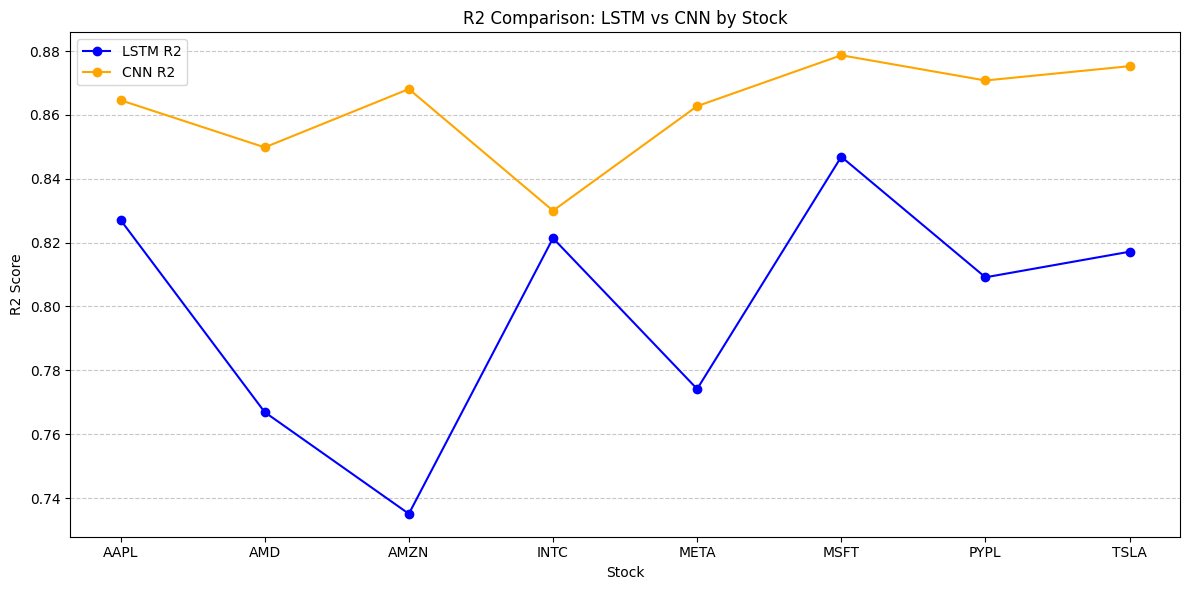

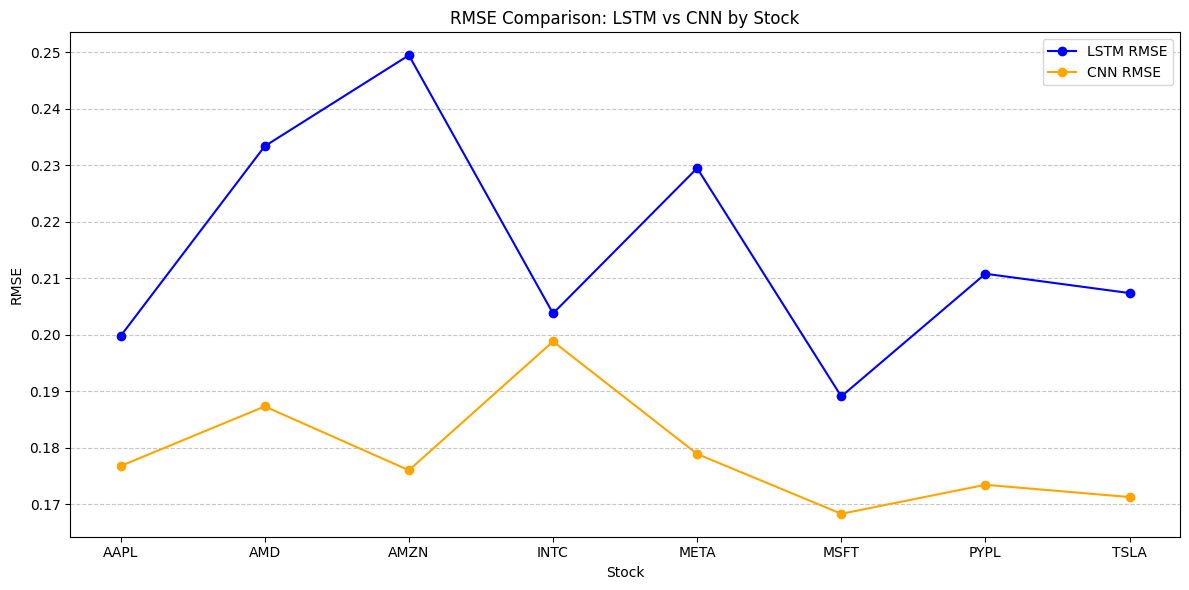

In [1269]:
# Line graph to compare R2 for LSTM and CNN
plt.figure(figsize=(12, 6))
plt.plot(results_df['Stock'], results_df['LSTM_R²'], marker='o', label='LSTM R2', color='blue')
plt.plot(results_df['Stock'], results_df['CNN_R²'], marker='o', label='CNN R2', color='orange')
plt.title("R2 Comparison: LSTM vs CNN by Stock")
plt.xlabel("Stock")
plt.ylabel("R2 Score")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Line graph to compare RMSE for LSTM and CNN
plt.figure(figsize=(12, 6))
plt.plot(results_df['Stock'], results_df['LSTM_RMSE'], marker='o', label='LSTM RMSE', color='blue')
plt.plot(results_df['Stock'], results_df['CNN_RMSE'], marker='o', label='CNN RMSE', color='orange')
plt.title("RMSE Comparison: LSTM vs CNN by Stock")
plt.xlabel("Stock")
plt.ylabel("RMSE")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## <span style="color:#4682B4">LSTM vs CNN Stock Price Prediction</span>

The performance of both **LSTM** and **CNN** models for predicting stock prices was evaluated using **R² (coefficient of determination)** and **RMSE (root mean squared error)** metrics across eight prominent stocks: AAPL, AMD, AMZN, INTC, META, MSFT, PYPL, and TSLA. Both models performed well overall, with CNN consistently achieving lower RMSE and higher R² values compared to LSTM. Below is the updated stock-wise and model-wise analysis based on the new results.

---

#### Stock-Wise Observations:

1. **AAPL**:
   - CNN outperformed LSTM with higher R² (**CNN: 0.8646, LSTM: 0.8271**) and lower RMSE (**CNN: 0.1768, LSTM: 0.1998**).
   - **Conclusion**: CNN is more effective for AAPL, capturing more variance and reducing error significantly.

2. **AMD**:
   - CNN achieved a higher R² (**CNN: 0.8498, LSTM: 0.7669**) and a lower RMSE (**CNN: 0.1873, LSTM: 0.2334**).
   - **Conclusion**: CNN performs significantly better for AMD, indicating stronger pattern detection in price trends.

3. **AMZN**:
   - CNN outperformed LSTM with higher R² (**CNN: 0.8681, LSTM: 0.7351**) and lower RMSE (**CNN: 0.1760, LSTM: 0.2495**).
   - **Conclusion**: CNN is clearly more effective for AMZN, excelling in both metrics.

4. **INTC**:
   - Both models performed well, but CNN slightly outperformed with a higher R² (**CNN: 0.8300, LSTM: 0.8214**) and lower RMSE (**CNN: 0.1988, LSTM: 0.2038**).
   - **Conclusion**: CNN is marginally better for INTC.

5. **META**:
   - CNN surpassed LSTM with higher R² (**CNN: 0.8628, LSTM: 0.7742**) and lower RMSE (**CNN: 0.1789, LSTM: 0.2295**).
   - **Conclusion**: CNN demonstrates stronger performance for META, effectively managing its volatility.

6. **MSFT**:
   - CNN achieved the highest R² among all stocks (**CNN: 0.8787, LSTM: 0.8469**) and the lowest RMSE (**CNN: 0.1683, LSTM: 0.1891**).
   - **Conclusion**: CNN is the better model for MSFT, capturing trends and reducing error effectively.

7. **PYPL**:
   - CNN outperformed LSTM in both R² (**CNN: 0.8708, LSTM: 0.8091**) and RMSE (**CNN: 0.1735, LSTM: 0.2108**).
   - **Conclusion**: CNN provides more accurate predictions for PYPL compared to LSTM.

8. **TSLA**:
   - CNN demonstrated better results with higher R² (**CNN: 0.8753, LSTM: 0.8172**) and lower RMSE (**CNN: 0.1713, LSTM: 0.2074**).
   - **Conclusion**: CNN handles TSLA’s volatility better than LSTM.

---

#### Model-Wise Observations:

1. **LSTM**:
   - LSTM performs consistently well across stocks but struggles to match CNN in reducing RMSE and maximizing R².
   - **Strengths**: Effective for stocks with smoother price trends (e.g., INTC, AAPL).
   - **Weaknesses**: Struggles with high-volatility stocks like TSLA and META.

2. **CNN**:
   - CNN outperforms LSTM across all stocks, with higher R² and lower RMSE for each stock.
   - **Strengths**: Excels in handling volatile stocks and capturing complex patterns in price movements.
   - **Weaknesses**: Marginal improvements over LSTM for certain stable stocks like INTC.

---

#### General Insights:

- **Stable Stocks**: For stocks like **AAPL** and **MSFT**, both models perform exceptionally well, but CNN consistently reduces RMSE and captures variance better.
- **Volatile Stocks**: For stocks like **META** and **TSLA**, CNN’s ability to capture intricate patterns gives it a significant advantage over LSTM.
- **Model Selection**: CNN emerges as the superior model overall, especially for managing volatility and achieving higher predictive accuracy.

---

### Final Conclusion:
The results highlight CNN’s superior performance across all stocks, achieving higher R² and lower RMSE compared to LSTM. This is likely due to CNN’s strength in capturing spatial patterns and handling volatile data. While LSTM remains effective, particularly for stable stocks, future improvements could involve hybrid architectures combining LSTM and CNN capabilities. Incorporating additional features like macroeconomic indicators or sentiment data could further enhance performance.